In [1]:
# import essential packages
import pandas as pd
import numpy as np
import re
import warnings

# sk-learn
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.metrics import log_loss

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# encoding
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

# sampling
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# models
from sklearn.ensemble import RandomForestClassifier,  GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
import lightgbm as lgb

# hyper-parameter tuning
from sklearn.model_selection import GridSearchCV, cross_val_score

In [2]:
# setting seed
np.random.seed(0)
warnings.filterwarnings('ignore')

In [3]:
# use this part, if you are using google colab
# from google.colab import drive
# drive.mount('/content/drive')

# Pre-processing data for visualization

In [4]:
df = pd.read_csv('DataCoSupplyChainDataset.csv', encoding ='latin-1')
# df = pd.read_csv('DataCoSupplyChainDataset.csv')

# converting datetime columns
df['order date (DateOrders)'] = pd.to_datetime(df['order date (DateOrders)'])
df['shipping date (DateOrders)'] = pd.to_datetime(df['shipping date (DateOrders)'])

df.head()


,Type,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Delivery Status,Late_delivery_risk,Category Id,Category Name,Customer City,...,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Image,Product Name,Product Price,Product Status,shipping date (DateOrders),Shipping Mode
0,DEBIT,3,4,91.250000,314.640015,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-02-03 22:56:00,Standard Class
1,TRANSFER,5,4,-249.089996,311.359985,Late delivery,1,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-01-18 12:27:00,Standard Class
2,CASH,4,4,-247.779999,309.720001,Shipping on time,0,73,Sporting Goods,San Jose,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-01-17 12:06:00,Standard Class
3,DEBIT,3,4,22.860001,304.809998,Advance shipping,0,73,Sporting Goods,Los Angeles,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-01-16 11:45:00,Standard Class
4,PAYMENT,2,4,134.210007,298.250000,Advance shipping,0,73,Sporting Goods,Caguas,...,NaN,1360,73,NaN,http://images.acmesports.sports/Smart+watch,Smart watch,327.75,0,2018-01-15 11:24:00,Standard Class


### Preventing Data Leakage by removing Delivery Status

In [5]:
# Filter the DataFrame for rows with 'Order Status' of 'SUSPECTED_FRAUD'
fraud_rows = df[df['Order Status'] == 'SUSPECTED_FRAUD']

# Check if all of these rows have 'Delivery Status' as 'Shipping canceled'
all_fraud_have_shipping_cancelled = fraud_rows['Delivery Status'].eq('Shipping canceled').all()

# Print the result
print(f"All rows with 'SUSPECTED_FRAUD' have 'Delivery Status' of 'Shipping canceled': {all_fraud_have_shipping_cancelled}")

All rows with 'SUSPECTED_FRAUD' have 'Delivery Status' of 'Shipping canceled': True


As observed, there is data leakage for suspected fraud in the column delivery status since all rows with suspected fraud has Delivery Status of "Shipping canceled". Hence the column delivery status is removed.

### Removing NA Columns

In [6]:
#display columns in the DataFrame that contain missing (NA) values and the percentage of missing values in each of those columns
na_viz=(df.isnull().sum()/len(df)).reset_index()
na_viz.loc[na_viz[0] > 0].sort_values(by=[0],ascending=False)

,index,0
46,Product Description,1.000000
43,Order Zipcode,0.862397
14,Customer Lname,0.000044
19,Customer Zipcode,0.000017


We removed the columns product description and order zipcode because :

'Product Description' column: it contains no data (100% missing values), and therefore, it does not contribute any meaningful information to our analysis or modeling.

'Order Zipcode' column: High percentage of missing values (approximately 86.24%). Columns with such a high rate of missing values can introduce noise and complexity into our analysis and are unlikely to provide valuable insights or predictive power. Removing these columns will help us maintain data quality, simplify our analysis, and reduce unnecessary dimensionality in our dataset.

### To prevent overfitting, we will be removing the following columns.


- 'Delivery Status' column: To prevent data leakage as mentioned previously
- ('Product Description', 'Order Zipcode') columns: High percentage of missing values as mentioned previously
- All id columns ('Department Id', 'Category Id', 'Customer Id', 'Order Customer Id', 'Product Card Id', 'Product Category Id'): They do not contribute any meaningful information to our analysis or modeling
- ('Customer Email', 'Customer Password') columns: These columns exclusively contain the value 'XXXXXXXXX' throughout the entire dataset, which does not contribute any meaningful information to our analysis or modeling
- ('Customer City', 'Customer Country', 'Customer Fname', 'Customer Lname','Customer State', 'Customer Street', 'Customer Zipcode'): These columns predominantly contain repetitive or uniform information that does not provide valuable insights for our analysis or modeling objectives. For instance, when we examine the data, we observe that these columns contain similar or identical values for a significant number of rows, indicating limited variability in the data. In a dataset analysis, it is essential to focus on features that exhibit meaningful variation and contribute to our understanding of the underlying patterns or relationships.
- ('Latitude', 'Longitude'): We observed that the 'Latitude' and 'Longitude' columns contain a multitude of distinct values, indicating a wide geographical spread. However, for our specific analysis or modeling tasks, the precise geographical coordinates of individual stores may not be a critical feature. Instead, we are primarily interested in other aspects of the data, such as customer behavior, order details, and product information. By removing the 'Latitude' and 'Longitude' columns, we can simplify the dataset, reduce the dimensionality, and focus our efforts on features that are more directly relevant to our goals. This allows us to streamline our analysis and modeling processes, making them more interpretable and efficient while retaining the essential information needed for our objectives. By removing these columns, we can streamline the dataset, reduce unnecessary dimensionality, and enhance the clarity of our analysis. This allows us to concentrate on more relevant and informative features that will contribute to our data-driven objectives, ensuring that our analysis is more focused and efficient.
- 'Sales' column: 'Sales' is a derived quantity that can be calculated exclusively from the 'Order Item Total' and 'Order Item Discount Rate' columns. These two columns provide us with all the necessary information to calculate the final sales amount for each order, considering any applicable discounts. By excluding the 'Sales' column, we aim to streamline our dataset and avoid redundancy. This approach ensures that we maintain data integrity while simplifying our feature set.
- ('Order State', 'Order Zipcode', 'Order City', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio'): These columns predominantly contain repetitive or uniform information that does not provide valuable insights for our analysis or modeling objectives. For instance, when we examine the data, we observe that these columns contain similar or identical values for a significant number of rows, indicating limited variability in the data. In a dataset analysis, it is essential to focus on features that exhibit meaningful variation and contribute to our understanding of the underlying patterns or relationships.
- 'Product Status' column: Consistently contains a single, constant value of 0 across all rows. This lack of variability means that the 'Product Status' column does not provide any meaningful or informative data that can contribute to our analysis or modeling objectives.
- 'Product Image' column: Redundant column. The 'Product Image' column contains URLs pointing to product images, and upon examination, we noticed that these URLs consistently refer to the same product, 'Smart watch.' This information is already adequately captured in the 'Product Name' column, which clearly states the name of the item.
- 'Product Price' column: Substantial similarity to the 'Order Item Product Price' column. Upon careful examination, it became evident that the 'Product Price' column represents prices that are already captured in the 'Order Item Product Price' column. Given this redundancy, retaining the 'Product Price' column would not yield any additional valuable insights or information for our analysis. Instead, it would introduce unnecessary duplication of data, potentially leading to multicollinearity issues and increased complexity in our dataset.

In [7]:
columns_to_drop = [
	'Delivery Status',
    'Product Description', 'Product Status', 'Product Image', 'Product Price', 'Product Card Id', 'Product Category Id',
    'Department Id', 'Category Id',
	'Customer Id', 'Order Customer Id',
    'Customer Email', 'Customer Password',
    'Customer City', 'Customer Country', 'Customer Fname', 'Customer Lname','Customer State', 'Customer Street', 'Customer Zipcode',
    'Latitude', 'Longitude',
    'Sales',
    'Order Zipcode', 'Order State', 'Order City', 'Order Item Cardprod Id', 'Order Item Discount', 'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price', 'Order Item Profit Ratio',
    ]

df = df.drop(columns_to_drop, axis=1)


<BarContainer object of 9 artists>

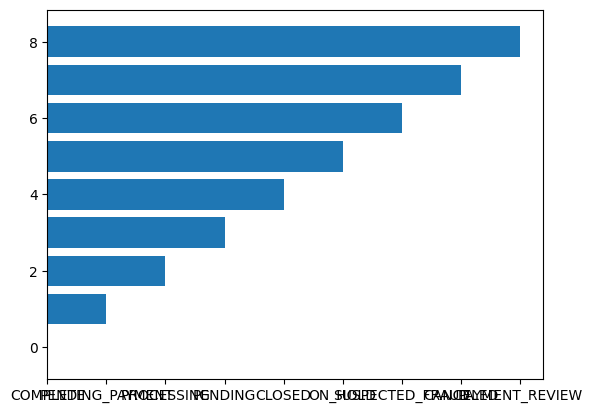

In [8]:
order = df["Order Status"].value_counts().reset_index()
plt.barh(order.index, order["Order Status"])

In [9]:
df["Order Id"].value_counts()
# Different rows can have same ids, thus there is a need to combine them

Order Id
48880    5
3605     5
28265    5
50037    5
27861    5
        ..
42011    1
42068    1
42072    1
42118    1
26118    1
Name: count, Length: 65752, dtype: int64

We realise that each row contains only one product of an order, hence there is a need to aggregate them to get the features of one entire order.

In [10]:
# removing cancelled orders that did not go through
df = df[df['Order Status'] != 'CANCELED']

# converting fraudulent transactions to 1, else 0
df['fraud'] = df['Order Status'].apply(lambda x: int(x == 'SUSPECTED_FRAUD'))
df['fraud'].value_counts()

fraud
0    172765
1      4062
Name: count, dtype: int64

### Shuffle Split

In [11]:
# train-test split
X_train, X_test = train_test_split(df['Order Id'].unique(), test_size = 0.3, random_state = 0, shuffle = True)
X_train = df[df['Order Id'].isin(X_train)]
X_test = df[df['Order Id'].isin(X_test)]

### One-hot encoding

In [12]:
# this function is to be used during aggregation, by mapping the number of items bought in that category per order
# very similar to one-hot encoding, but instead of binary, we have the number of items bought for that category

def one_hot(df_train, df_test, col):
    category = list(df_train[col].unique())
    test_category = list(df_test[col].unique())

    for cat in category:
        newname = col + ': ' + cat
        df_train[newname] = df_train[col].apply(lambda x: int(x == cat))
        df_train[newname] = df_train[newname] * df_train['Order Item Quantity']
        df_test[newname] = df_test[col].apply(lambda x: int(x == cat))
        df_test[newname] = df_test[newname] * df_test['Order Item Quantity']

    # add unknown category, df_train should not have any unknowns
    # if any unknowns we add into 'Unknown' category
    unknown = col + ': Unknown'
    df_train[unknown] = 0
    df_test[unknown] = 0

    for cat in test_category:
        if cat not in category:
            df_test[unknown] = df_test['Order Item Quantity']


one_hot(X_train, X_test, 'Category Name')
one_hot(X_train, X_test, 'Product Name')
one_hot(X_train, X_test, 'Department Name')

# more sanity checks
# print('Train set: ')
# print(X_train['Category Name: Golf Gloves'].value_counts())
# print('\n Test set:')
# print(X_test['Category Name: Golf Gloves'].value_counts())

# test whether the no.of cols are the same
print(X_train.shape[1] == X_test.shape[1])

True


In [13]:
# encoded variables start from col 22 onwards
X_train.columns[22:]

Index(['Category Name: Sporting Goods', 'Category Name: Shop By Sport',
       'Category Name: Women's Apparel', 'Category Name: Electronics',
       'Category Name: Boxing & MMA', 'Category Name: Cleats',
       'Category Name: Cardio Equipment', 'Category Name: Trade-In',
       'Category Name: Kids' Golf Clubs', 'Category Name: Hunting & Shooting',
       ...
       'Department Name: Footwear', 'Department Name: Apparel',
       'Department Name: Outdoors', 'Department Name: Fan Shop',
       'Department Name: Technology', 'Department Name: Book Shop',
       'Department Name: Discs Shop', 'Department Name: Pet Shop',
       'Department Name: Health and Beauty ', 'Department Name: Unknown'],
      dtype='object', length=182)

### Aggregating rows by Order Id

We selected the relevant features before aggregating the rows. The categorical features are combined into a list of unique values for by order id to make sure that the one order only has one common value for each categorical feature.

In [14]:
# selecting the relevant features then aggregating the rows, leaving it as a list for sanity check
X_train_grouped = X_train.groupby('Order Id').agg(
    num_distinct_items = ('Type', lambda x: len(x)),
    payment_type = ('Type', lambda x: list(pd.unique(x))),
    late_delivery_risk = ('Late_delivery_risk', lambda x: list(pd.unique(x))),
	customer_segment = ('Customer Segment', lambda x: list(pd.unique(x))),
	market = ('Market', lambda x: list(pd.unique(x))),
	order_country = ('Order Country', lambda x: list(pd.unique(x))),
	order_item_quantity = ('Order Item Quantity', 'sum'),
	order_total = ('Order Item Total', 'sum'),
	order_region = ('Order Region', lambda x: list(pd.unique(x))),
	shipping_mode = ('Shipping Mode', lambda x: list(pd.unique(x))),
	shipping_date = ('shipping date (DateOrders)', lambda x: list(pd.unique(x))),
	order_date = ('order date (DateOrders)', lambda x: list(pd.unique(x))),
	fraud = ('fraud', lambda x: list(pd.unique(x)))
)

X_test_grouped = X_test.groupby('Order Id').agg(
    num_distinct_items = ('Type', lambda x: len(x)),
    payment_type = ('Type', lambda x: list(pd.unique(x))),
    late_delivery_risk = ('Late_delivery_risk', lambda x: list(pd.unique(x))),
	customer_segment = ('Customer Segment', lambda x: list(pd.unique(x))),
	market = ('Market', lambda x: list(pd.unique(x))),
	order_country = ('Order Country', lambda x: list(pd.unique(x))),
	order_item_quantity = ('Order Item Quantity', 'sum'),
	order_total = ('Order Item Total', 'sum'),
	order_region = ('Order Region', lambda x: list(pd.unique(x))),
	shipping_mode = ('Shipping Mode', lambda x: list(pd.unique(x))),
	shipping_date = ('shipping date (DateOrders)', lambda x: list(pd.unique(x))),
	order_date = ('order date (DateOrders)', lambda x: list(pd.unique(x))),
	fraud = ('fraud', lambda x: list(pd.unique(x)))
)

# # aggregate the previous encoded columns using 'sum'
X_train_grouped = X_train_grouped.join(X_train[['Order Id'] + list(X_train.columns[22:])].groupby('Order Id').agg('sum'))
X_test_grouped = X_test_grouped.join(X_test[['Order Id'] + list(X_test.columns[22:])].groupby('Order Id').agg('sum'))

In [15]:
# sanity check to see which columns have lists, and if they have more than 1 unique values
# these columns need to be one-hot encoded previously

def is_list(x):
    return isinstance(x, list)

columns_with_lists = []

# iterate through DataFrame columns and check for lists
for column in X_train_grouped.columns:
    if X_train_grouped[column].apply(lambda x: isinstance(x, list) and len(x) > 1).any():
        columns_with_lists.append(column)

# print the column names with lists
print("Columns containing lists of more than one value:")
for column in columns_with_lists:
    print(column)

Columns containing lists of more than one value:


In [16]:
# transform the lists to single-value for those with only one value in the list
for column in X_train_grouped.columns:
    if X_train_grouped[column].apply(lambda x: isinstance(x, list) and len(x) == 1).all():
        print(column)
        X_train_grouped[column] = X_train_grouped[column].apply(lambda x: x[0])

for column in X_test_grouped.columns:
    if X_test_grouped[column].apply(lambda x: isinstance(x, list) and len(x) == 1).all():
        X_test_grouped[column] = X_test_grouped[column].apply(lambda x: x[0])

X_train_grouped = X_train_grouped.reset_index(drop=True)
X_test_grouped = X_test_grouped.reset_index(drop=True)
X_train_grouped.head()

payment_type
late_delivery_risk
customer_segment
market
order_country
order_region
shipping_mode
shipping_date
order_date
fraud


,num_distinct_items,payment_type,late_delivery_risk,customer_segment,market,order_country,order_item_quantity,order_total,order_region,shipping_mode,...,Department Name: Footwear,Department Name: Apparel,Department Name: Outdoors,Department Name: Fan Shop,Department Name: Technology,Department Name: Book Shop,Department Name: Discs Shop,Department Name: Pet Shop,Department Name: Health and Beauty,Department Name: Unknown
0,3,PAYMENT,0,Consumer,LATAM,Colombia,7,529.380005,South America,Standard Class,...,0,1,0,1,0,0,0,0,0,0
1,5,DEBIT,1,Consumer,LATAM,Colombia,10,987.070007,South America,Standard Class,...,0,6,0,4,0,0,0,0,0,0
2,3,DEBIT,1,Consumer,LATAM,Brasil,7,525.520004,South America,Second Class,...,0,0,5,2,0,0,0,0,0,0
3,3,PAYMENT,1,Consumer,LATAM,Brasil,4,587.960007,South America,Standard Class,...,2,0,0,2,0,0,0,0,0,0
4,5,PAYMENT,1,Corporate,LATAM,Brasil,6,525.770010,South America,Standard Class,...,0,1,1,4,0,0,0,0,0,0


In [17]:
# Extracting information from order_date
X_train_grouped['order_month'] = X_train_grouped['order_date'].dt.month
X_train_grouped['order_weekday'] = X_train_grouped['order_date'].dt.day
X_train_grouped['order_hour'] = X_train_grouped['order_date'].dt.hour

X_test_grouped['order_month'] = X_test_grouped['order_date'].dt.month
X_test_grouped['order_weekday'] = X_test_grouped['order_date'].dt.day
X_test_grouped['order_hour'] = X_test_grouped['order_date'].dt.hour

X_train_grouped.drop(columns='order_date', axis=1, inplace=True)
X_test_grouped.drop(columns='order_date', axis=1, inplace=True)

# Extracting information from shipping_date
X_train_grouped['shipping_month'] = X_train_grouped['shipping_date'].dt.month
X_train_grouped['shipping_weekday'] = X_train_grouped['shipping_date'].dt.day
X_train_grouped['shipping_hour'] = X_train_grouped['shipping_date'].dt.hour

X_test_grouped['shipping_month'] = X_test_grouped['shipping_date'].dt.month
X_test_grouped['shipping_weekday'] = X_test_grouped['shipping_date'].dt.day
X_test_grouped['shipping_hour'] = X_test_grouped['shipping_date'].dt.hour

X_train_grouped.drop(columns='shipping_date', axis=1, inplace=True)
X_test_grouped.drop(columns='shipping_date', axis=1, inplace=True)

#X_train_grouped.to_csv('train_check.csv', index=False)

In [18]:
X_train_grouped

,num_distinct_items,payment_type,late_delivery_risk,customer_segment,market,order_country,order_item_quantity,order_total,order_region,shipping_mode,...,Department Name: Discs Shop,Department Name: Pet Shop,Department Name: Health and Beauty,Department Name: Unknown,order_month,order_weekday,order_hour,shipping_month,shipping_weekday,shipping_hour
0,3,PAYMENT,0,Consumer,LATAM,Colombia,7,529.380005,South America,Standard Class,...,0,0,0,0,1,1,0,1,4,0
1,5,DEBIT,1,Consumer,LATAM,Colombia,10,987.070007,South America,Standard Class,...,0,0,0,0,1,1,1,1,7,1
2,3,DEBIT,1,Consumer,LATAM,Brasil,7,525.520004,South America,Second Class,...,0,0,0,0,1,1,2,1,4,2
3,3,PAYMENT,1,Consumer,LATAM,Brasil,4,587.960007,South America,Standard Class,...,0,0,0,0,1,1,2,1,6,2
4,5,PAYMENT,1,Corporate,LATAM,Brasil,6,525.770010,South America,Standard Class,...,0,0,0,0,1,1,3,1,7,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45064,1,DEBIT,1,Home Office,Pacific Asia,Indonesia,1,211.500000,Southeast Asia,Second Class,...,0,0,0,0,1,31,21,2,3,21
45065,1,PAYMENT,1,Consumer,Pacific Asia,Australia,1,215.820007,Oceania,First Class,...,0,0,0,0,1,31,21,2,2,21
45066,1,TRANSFER,1,Consumer,Pacific Asia,Indonesia,1,161.869995,Southeast Asia,Standard Class,...,0,0,0,0,1,31,22,2,6,22
45067,1,DEBIT,0,Consumer,Pacific Asia,Indonesia,1,172.660004,Southeast Asia,Standard Class,...,0,0,0,0,1,31,22,2,2,22


# Exploratory Data Visualization

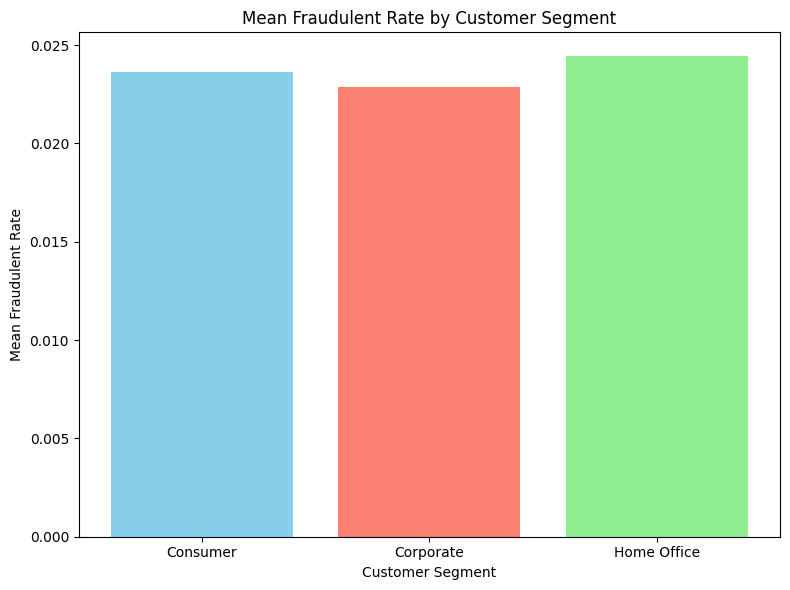

In [19]:
# visualize customer segment
fraudulent_mean = X_test_grouped.groupby('customer_segment')['fraud'].mean().reset_index()

# create a bar chart
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral']
plt.figure(figsize=(8, 6))
plt.bar(fraudulent_mean['customer_segment'], fraudulent_mean['fraud'], color = colors)
plt.xlabel('Customer Segment')
plt.ylabel('Mean Fraudulent Rate')
plt.title('Mean Fraudulent Rate by Customer Segment')
plt.tight_layout()

# Show the plot
plt.show()

As we can see, there is a slight distribution in fraudulent ratios, and we can potentially keep this feature in our ML model

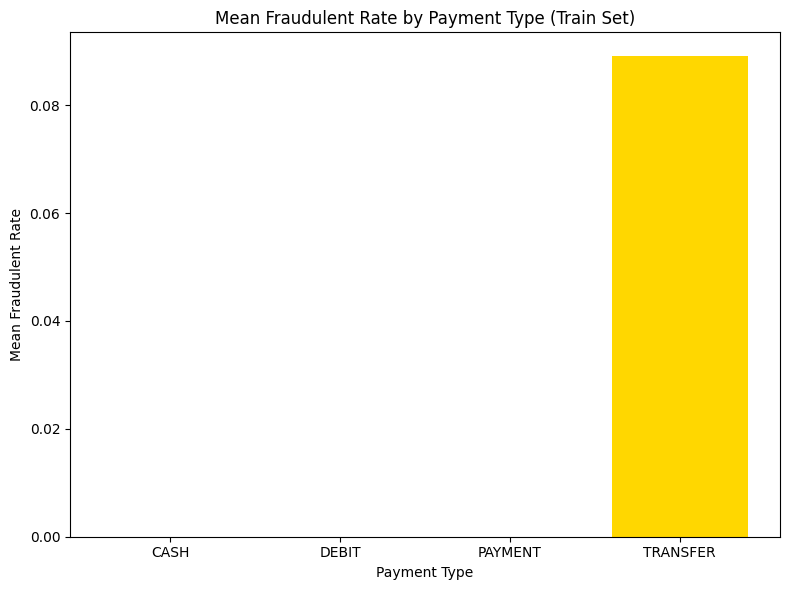

In [20]:
# visualize payment type
fraudulent_mean = X_train_grouped.groupby('payment_type')['fraud'].mean().reset_index()

# create a bar chart
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral']
plt.figure(figsize=(8, 6))
plt.bar(fraudulent_mean['payment_type'], fraudulent_mean['fraud'], color = colors)
plt.xlabel('Payment Type')
plt.ylabel('Mean Fraudulent Rate')
plt.title('Mean Fraudulent Rate by Payment Type (Train Set)')
plt.tight_layout()

# Show the plot
plt.show()

This particular chart was interesting, as we found out that all the fraudulent transactions are done through transfers.

In [21]:
# let's do a sanity check to test if non-fraudulent transactions has TRANSFER payment type
# if no, there may be some form of data leakage
print('Fraudulent Transactions:')
print(X_train_grouped[X_train_grouped['fraud'] == 1]['payment_type'].value_counts())
print('\nNon-fraudulent Transactions:')
print(X_train_grouped[X_train_grouped['fraud'] == 0]['payment_type'].value_counts())

Fraudulent Transactions:
payment_type
TRANSFER    1033
Name: count, dtype: int64

Non-fraudulent Transactions:
payment_type
DEBIT       17846
TRANSFER    10565
PAYMENT     10559
CASH         5066
Name: count, dtype: int64


As we can see, not all TRANSFER payment types are fraudulent, it's just that ALL fraudulent transactions are TRANSFER. Some non-fraudulent payment types can be TRANSFER too. What we may want to do is convert the PAYMENT type category into 1 for TRANSFER and 0 for NON-TRANSFER to reduce dimensionality

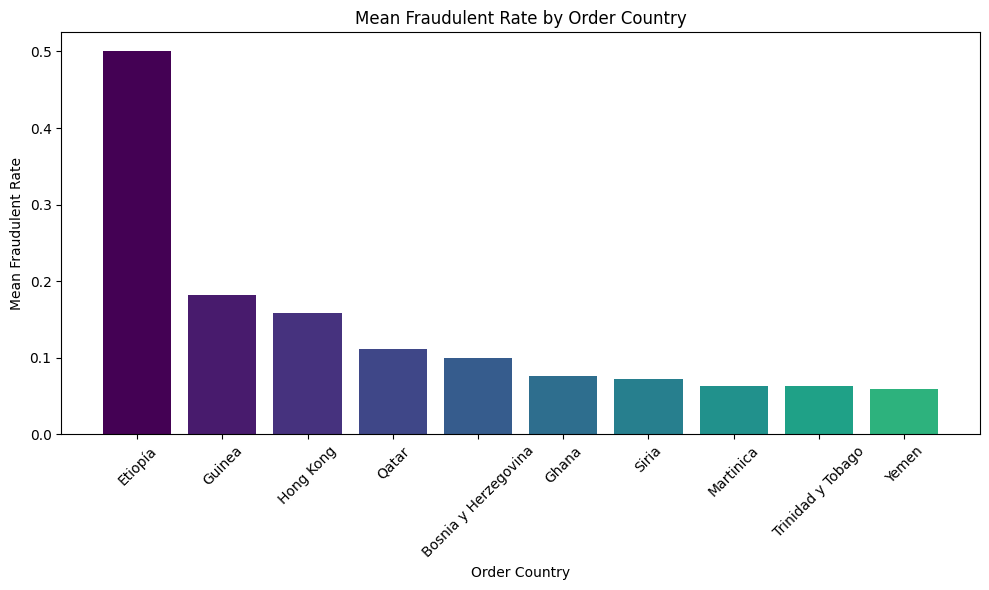

In [22]:
# visualize order country
fraudulent_mean = X_train_grouped.groupby('order_country')['fraud'].mean().reset_index()

# sort the country and get top 10
sorted_countries = fraudulent_mean.sort_values(by='fraud', ascending=False)
top_10_countries = sorted_countries.head(10)

# create a bar chart
colors = plt.cm.viridis(np.linspace(0, 1, 15))
plt.figure(figsize=(10, 6))
plt.bar(top_10_countries['order_country'], top_10_countries['fraud'], color = colors)
plt.xlabel('Order Country')
plt.ylabel('Mean Fraudulent Rate')
plt.title('Mean Fraudulent Rate by Order Country')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

However, one caveat is that there may be too many countries (162 total), may consider using MARKET instead

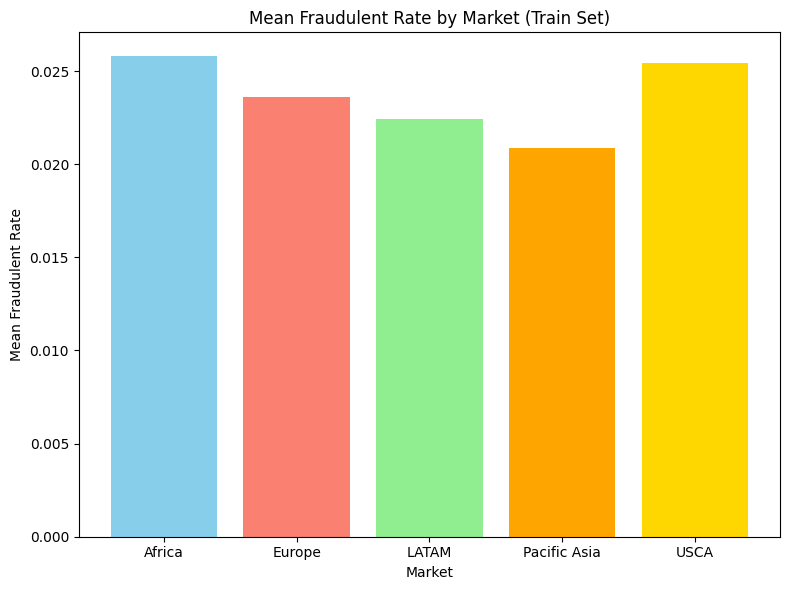

In [23]:
# visualize market
fraudulent_mean = X_train_grouped.groupby('market')['fraud'].mean().reset_index()

# create a bar chart
colors = ['skyblue', 'salmon', 'lightgreen', 'orange', 'gold']
plt.figure(figsize=(8, 6))
plt.bar(fraudulent_mean['market'], fraudulent_mean['fraud'], color = colors)
plt.xlabel('Market')
plt.ylabel('Mean Fraudulent Rate')
plt.title('Mean Fraudulent Rate by Market (Train Set)')
plt.tight_layout()

# Show the plot
plt.show()

The fraudulent rate seems to differ between markets, so we can consider using it as a feature to predict fraud.

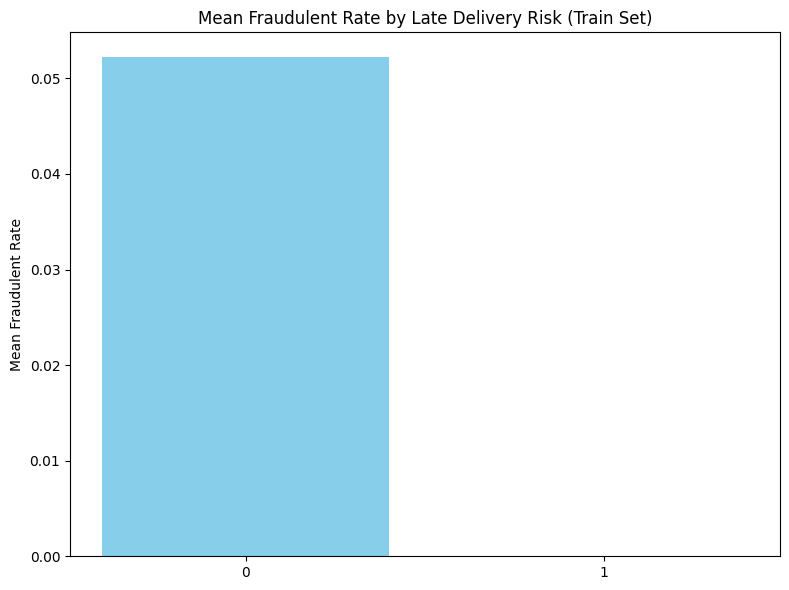

In [24]:
# visualize late delivery
fraudulent_mean = X_train_grouped.groupby('late_delivery_risk')['fraud'].mean().reset_index()

# Create a bar chart to visualize the distribution
plt.figure(figsize=(8, 6))
plt.bar(fraudulent_mean['late_delivery_risk'], fraudulent_mean['fraud'], color='skyblue')
plt.ylabel('Mean Fraudulent Rate')
plt.title('Mean Fraudulent Rate by Late Delivery Risk (Train Set)')
plt.xticks(fraudulent_mean['late_delivery_risk'])
plt.tight_layout()

# Show the plot
plt.show()

This is abit weird, it implies that if there is no late-delivery risk, then it will definitely not be fraudulent (at least in train set). However, if there is late-delivery risk, it can be fraudulent or non-fraudulent

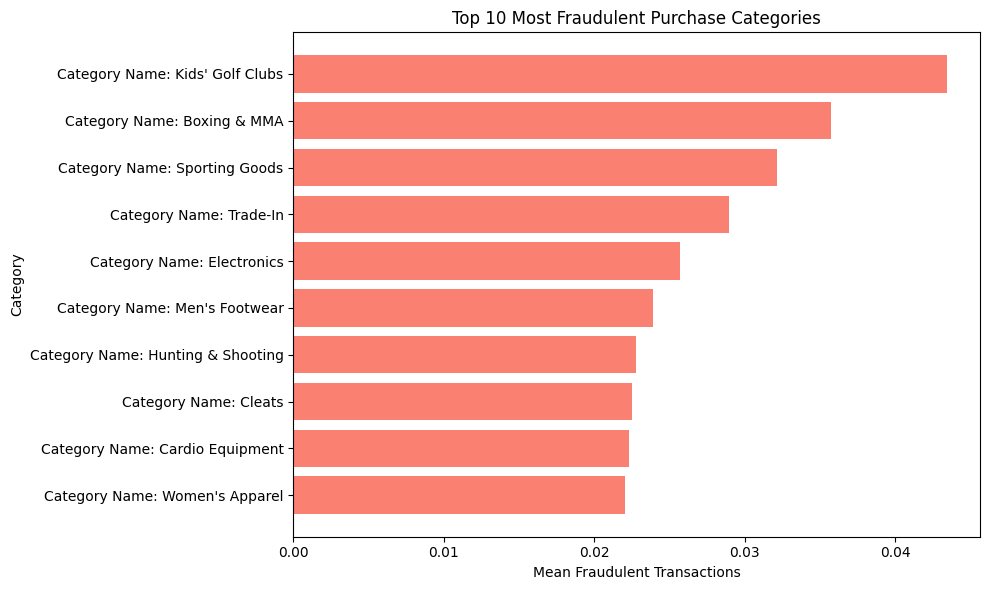

In [25]:
# taking out the one-hot encoded category names
category_names = X_train_grouped.columns[11:23]

# getting mean fraudulent transactions for each category
avg_category_fraud = {}
for category in category_names:
    # skip non-existent categories
    if X_train_grouped[category].apply(lambda x: 1 if x > 0 else 0).sum() == 0:
        print(category)
        continue
    avg_fraud = X_train_grouped[X_train_grouped['fraud'] == 1][category].apply(lambda x: 1 if x > 0 else 0).sum()/X_train_grouped[category].apply(lambda x: 1 if x > 0 else 0).sum()

    # this is to remove the 'Category Name: ' infront
    category = category
    avg_category_fraud[category] = avg_fraud

# sorting it and getting top 10
sorted_categories = sorted(avg_category_fraud.items(), key=lambda x: x[1], reverse=True)
top_10_fraudulent_categories = sorted_categories[:10]

# plotting it
categories, fraud_counts = zip(*top_10_fraudulent_categories)

plt.figure(figsize=(10, 6))
plt.barh(categories, fraud_counts, color='salmon')
plt.xlabel('Mean Fraudulent Transactions')
plt.ylabel('Category')
plt.title('Top 10 Most Fraudulent Purchase Categories')
plt.gca().invert_yaxis()  # invert the y-axis to show the highest count at the top
plt.tight_layout()

# show plot
plt.show()

In [26]:
X_train_grouped.columns

Index(['num_distinct_items', 'payment_type', 'late_delivery_risk',
       'customer_segment', 'market', 'order_country', 'order_item_quantity',
       'order_total', 'order_region', 'shipping_mode',
       ...
       'Department Name: Discs Shop', 'Department Name: Pet Shop',
       'Department Name: Health and Beauty ', 'Department Name: Unknown',
       'order_month', 'order_weekday', 'order_hour', 'shipping_month',
       'shipping_weekday', 'shipping_hour'],
      dtype='object', length=199)

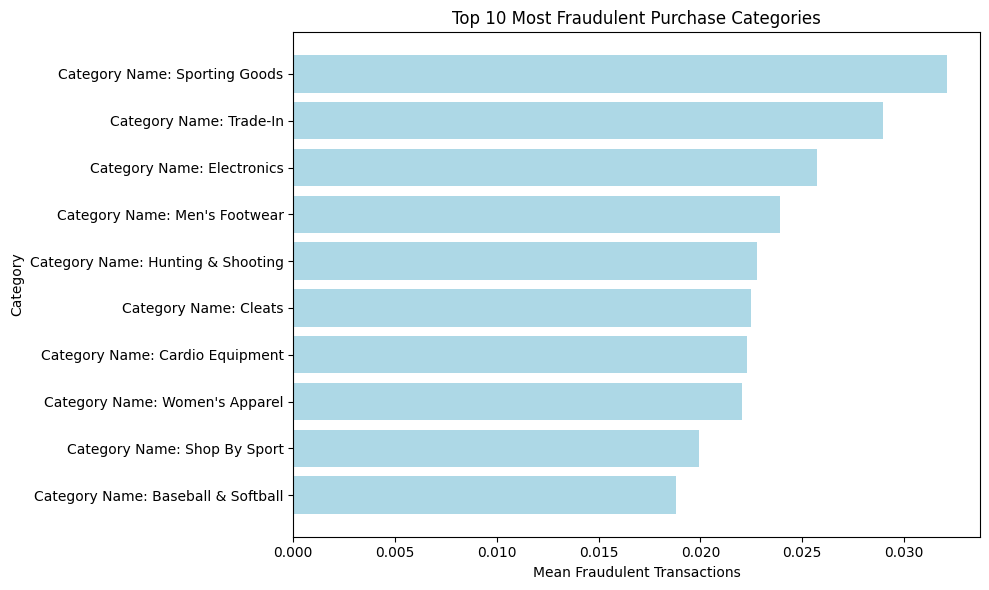

In [27]:
# plot the least fraudulent transactions
bottom_10_fraudulent_categories = sorted_categories[-10:]

# plotting it
categories, fraud_counts = zip(*bottom_10_fraudulent_categories)

plt.figure(figsize=(10, 6))
plt.barh(categories, fraud_counts, color='lightblue')
plt.xlabel('Mean Fraudulent Transactions')
plt.ylabel('Category')
plt.title('Top 10 Most Fraudulent Purchase Categories')
plt.gca().invert_yaxis()  # invert the y-axis to show the highest count at the top
plt.tight_layout()

# show plot
plt.show()

We can keep the top 10 & bottom 10 categories to help us determine fraudulent transactions?

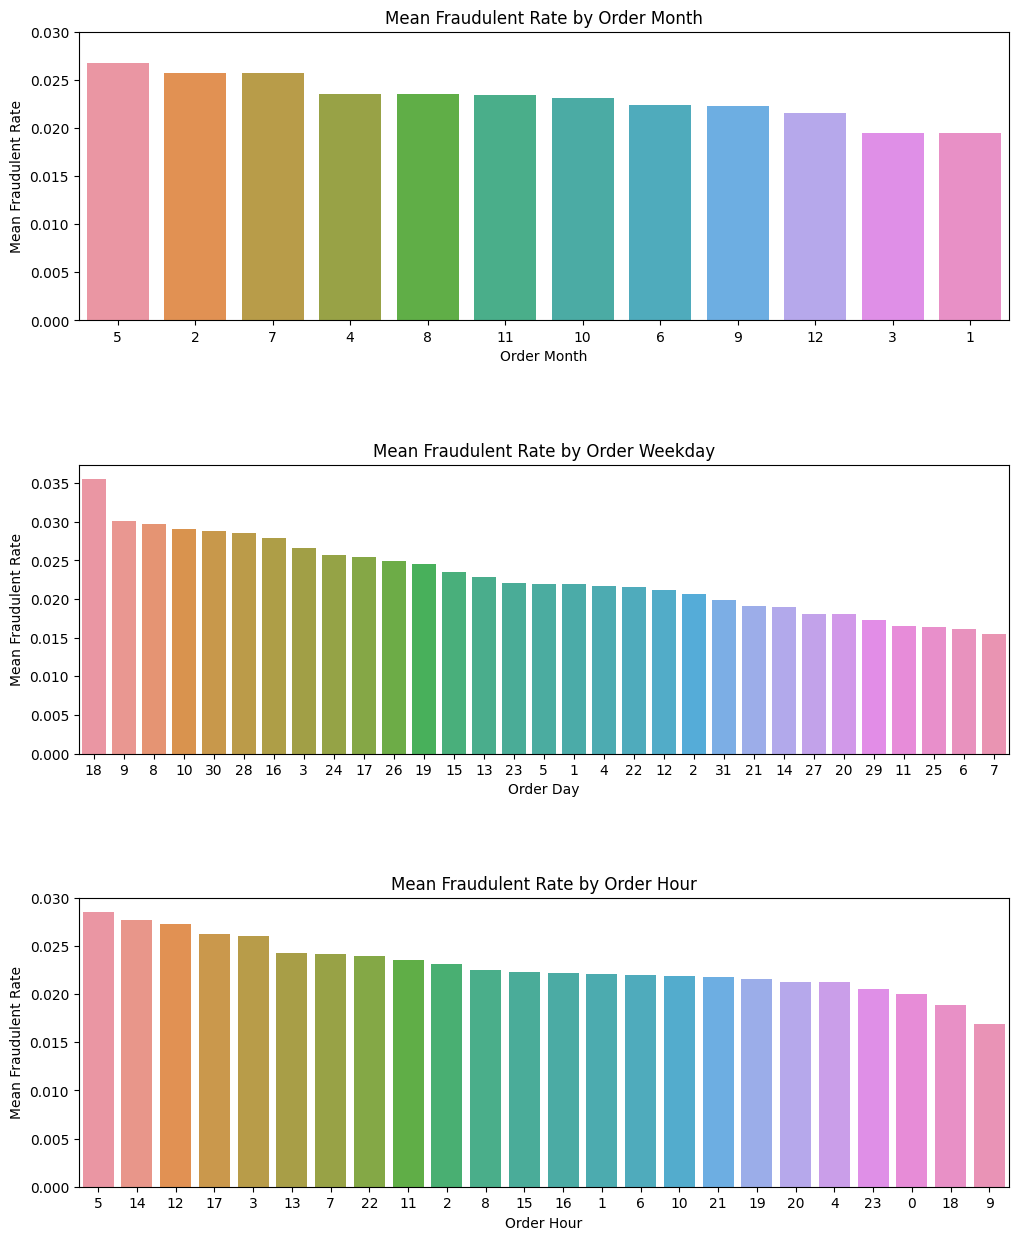

In [28]:
fig, ax = plt.subplots(3, 1, figsize=(12,15))
fig.subplots_adjust(hspace=0.5)

order_month_prop = X_train_grouped.groupby('order_month')['fraud'].mean().sort_values(ascending=False)
order_weekday_prop = X_train_grouped.groupby('order_weekday')['fraud'].mean().sort_values(ascending=False)
order_hour_prop = X_train_grouped.groupby('order_hour')['fraud'].mean().sort_values(ascending=False)

sns.barplot(x=order_month_prop.index, y=order_month_prop.values, ax=ax[0], order=order_month_prop.index)
ax[0].set_title('Mean Fraudulent Rate by Order Month')
ax[0].set_ylabel('Mean Fraudulent Rate')
ax[0].set_xlabel('Order Month')
ax[0].set_ylim([0, 0.03])
sns.barplot(x=order_weekday_prop.index, y=order_weekday_prop.values, ax=ax[1], order=order_weekday_prop.index)
ax[1].set_title('Mean Fraudulent Rate by Order Weekday')
ax[1].set_ylabel('Mean Fraudulent Rate')
ax[1].set_xlabel('Order Day')
sns.barplot(x=order_hour_prop.index, y=order_hour_prop.values, ax=ax[2], order=order_hour_prop.index)
ax[2].set_title('Mean Fraudulent Rate by Order Hour')
ax[2].set_ylabel('Mean Fraudulent Rate')
ax[2].set_xlabel('Order Hour')
ax[2].set_ylim([0, 0.03])
plt.show()

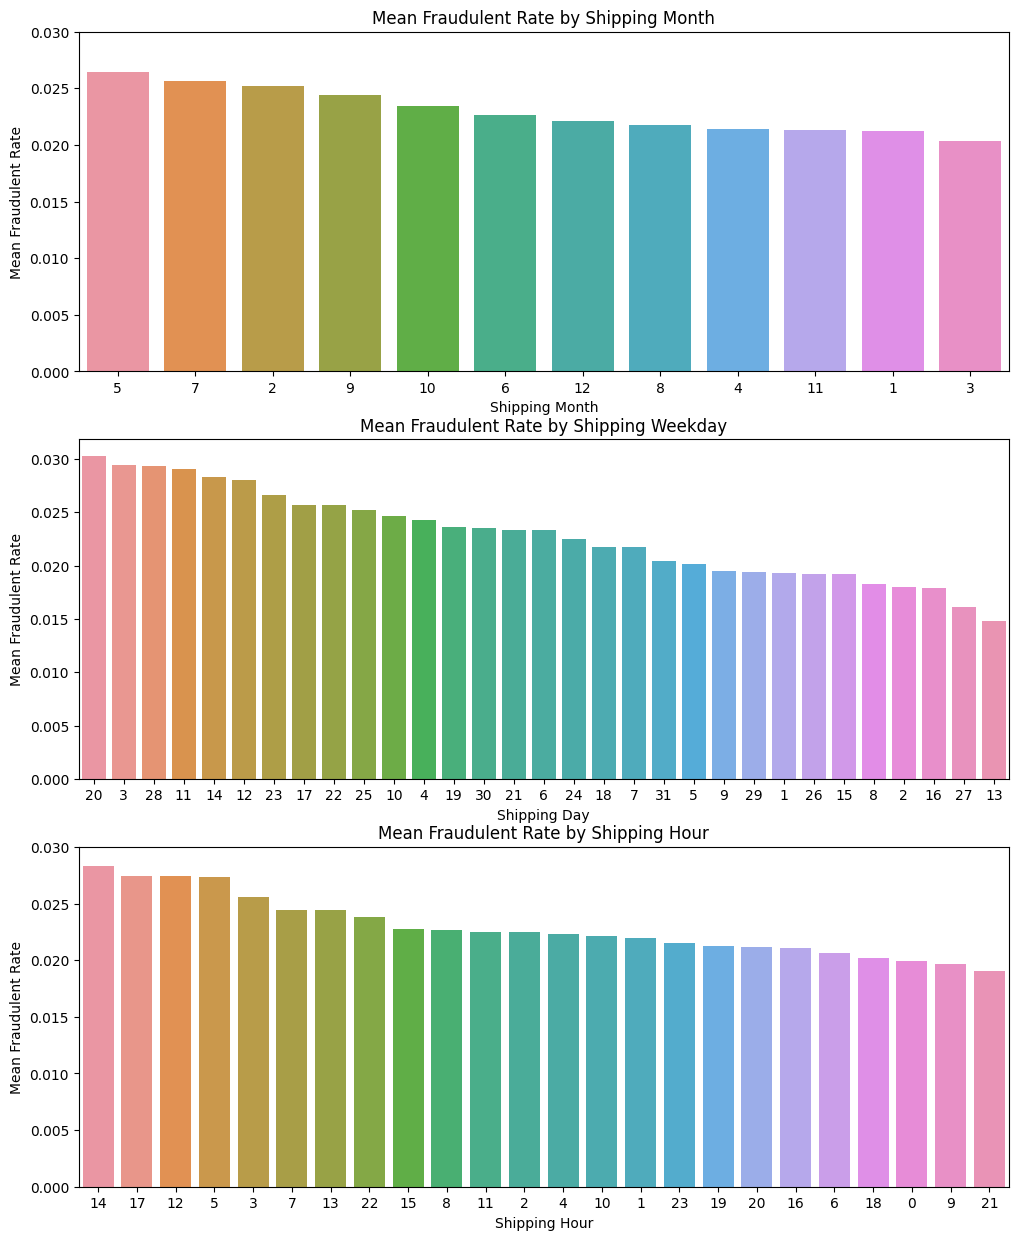

In [29]:
fig, ax = plt.subplots(3, 1, figsize=(12,15))

shipping_month_prop = X_train_grouped.groupby('shipping_month')['fraud'].mean().sort_values(ascending=False)
shipping_weekday_prop = X_train_grouped.groupby('shipping_weekday')['fraud'].mean().sort_values(ascending=False)
shipping_hour_prop = X_train_grouped.groupby('shipping_hour')['fraud'].mean().sort_values(ascending=False)

sns.barplot(x=shipping_month_prop.index, y=shipping_month_prop.values, ax=ax[0], order=shipping_month_prop.index)
ax[0].set_title('Mean Fraudulent Rate by Shipping Month')
ax[0].set_ylabel('Mean Fraudulent Rate')
ax[0].set_xlabel('Shipping Month')
ax[0].set_ylim([0, 0.03])
sns.barplot(x=shipping_weekday_prop.index, y=shipping_weekday_prop.values, ax=ax[1], order=shipping_weekday_prop.index)
ax[1].set_title('Mean Fraudulent Rate by Shipping Weekday')
ax[1].set_ylabel('Mean Fraudulent Rate')
ax[1].set_xlabel('Shipping Day')
sns.barplot(x=shipping_hour_prop.index, y=shipping_hour_prop.values, ax=ax[2], order=shipping_hour_prop.index)
ax[2].set_title('Mean Fraudulent Rate by Shipping Hour')
ax[2].set_ylabel('Mean Fraudulent Rate')
ax[2].set_xlabel('Shipping Hour')
ax[2].set_ylim([0, 0.03])
plt.show()


### Checking for outliers (numerical data)

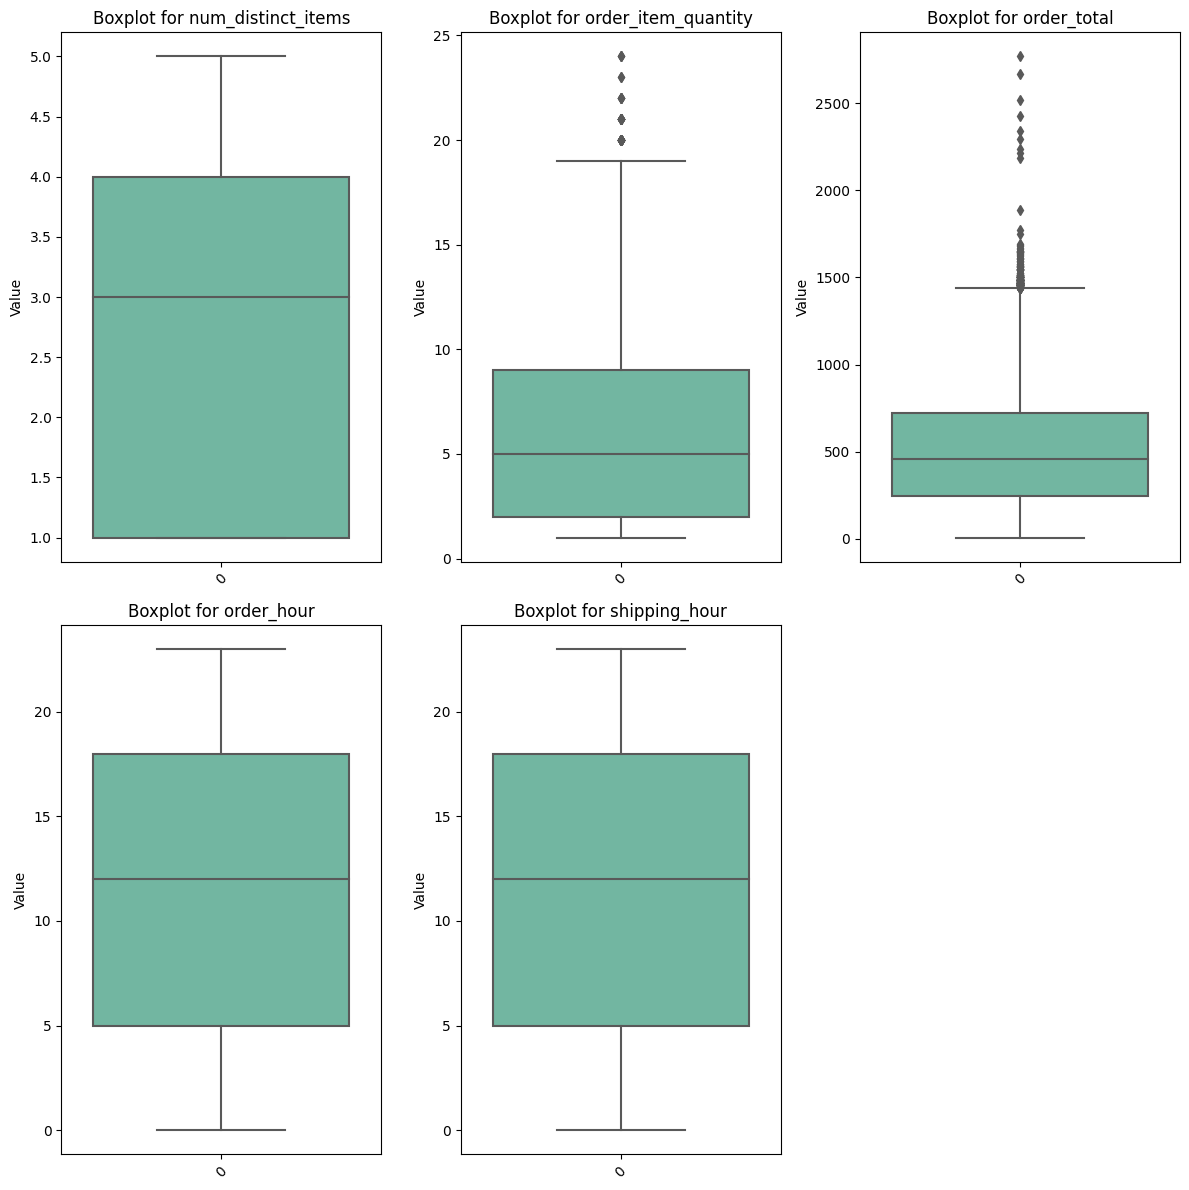

In [30]:
# Select the numerical variables
numerical_vars = ['num_distinct_items', 'order_item_quantity', 'order_total', 'order_hour', 'shipping_hour']

# Create a 3x2 grid of subplots for separate boxplots
fig, axes = plt.subplots(2, 3, figsize=(12, 12))

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Create individual boxplots for each numerical variable
for i, var in enumerate(numerical_vars):
    sns.boxplot(data=X_train_grouped[var], orient="v", palette="Set2", ax=axes[i])
    axes[i].set_title(f"Boxplot for {var}")
    axes[i].set_ylabel("Value")
    axes[i].tick_params(axis='x', rotation=45)

# Remove any empty subplots if the number of variables is less than 6
if len(numerical_vars) < 6:
    for i in range(len(numerical_vars), 6):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


num_distinct_items
order_item_quantity
order_total
order_hour
shipping_hour


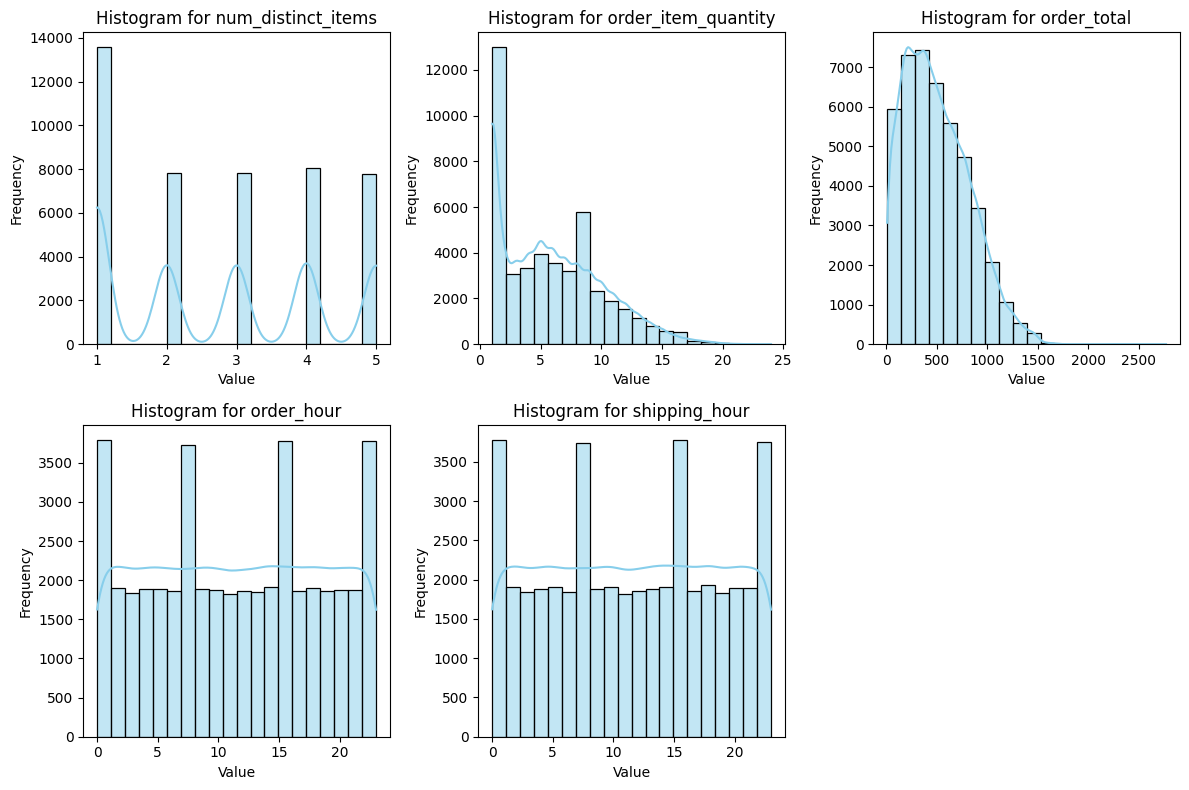

In [31]:
# Select the numerical variables
numerical_vars = ['num_distinct_items', 'order_item_quantity', 'order_total', 'order_hour', 'shipping_hour']

# Create a 2x3 grid of subplots for histograms
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Flatten the axes array for easy iteration
axes = axes.ravel()

# Create histograms for each numerical variable
for i, var in enumerate(numerical_vars):
    print(var)
    sns.histplot(data=X_train_grouped[var], bins=20, kde=True, ax=axes[i], color='skyblue')
    axes[i].set_title(f"Histogram for {var}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")

# Remove any empty subplots if the number of variables is less than 6
if len(numerical_vars) < 6:
    for i in range(len(numerical_vars), 6):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


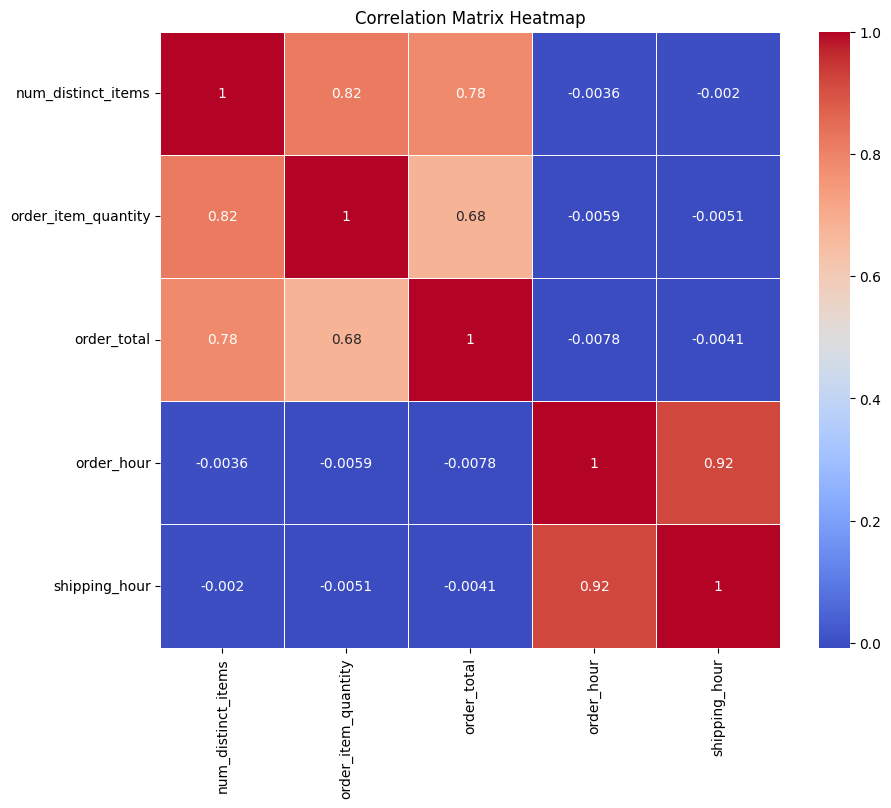

In [32]:
# Select the numerical variables
numerical_vars = ['num_distinct_items', 'order_item_quantity', 'order_total', 'order_hour', 'shipping_hour']

# Calculate the correlation matrix
correlation_matrix = X_train_grouped[numerical_vars].corr()

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()


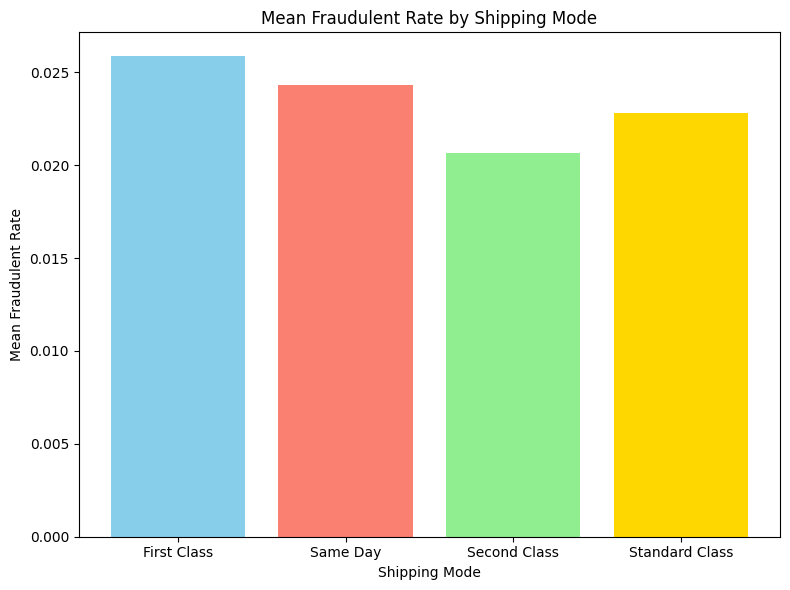

In [33]:
# visualize customer segment
fraudulent_mean = X_train_grouped.groupby('shipping_mode')['fraud'].mean().reset_index()

# create a bar chart
colors = ['skyblue', 'salmon', 'lightgreen', 'gold', 'lightcoral']
plt.figure(figsize=(8, 6))
plt.bar(fraudulent_mean['shipping_mode'], fraudulent_mean['fraud'], color = colors)
plt.xlabel('Shipping Mode')
plt.ylabel('Mean Fraudulent Rate')
plt.title('Mean Fraudulent Rate by Shipping Mode')
plt.tight_layout()

# Show the plot
plt.show()

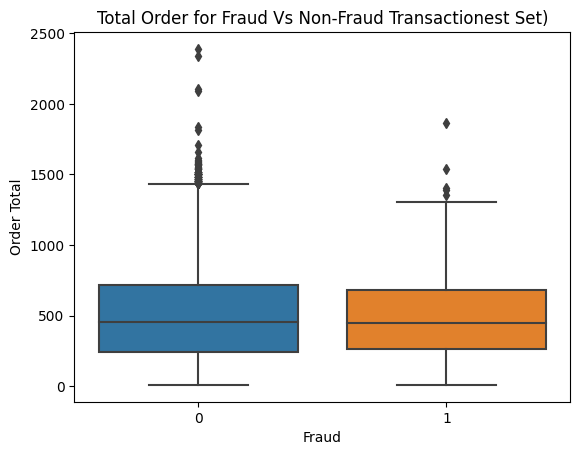

In [34]:
sns.boxplot(x='fraud', y='order_total', data=X_test_grouped)
plt.xlabel('Fraud')
plt.ylabel('Order Total')
plt.title('Total Order for Fraud Vs Non-Fraud Transactionest Set)')
plt.show()

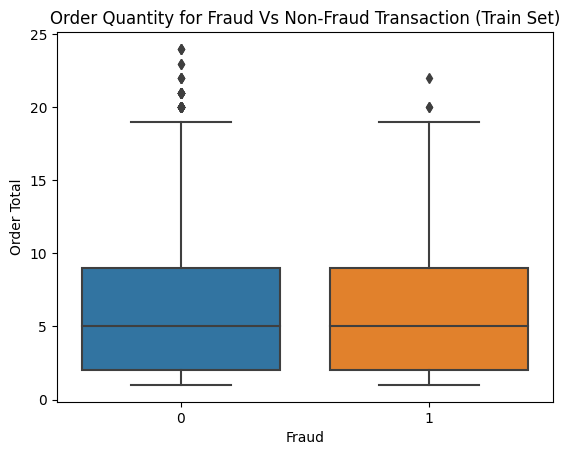

In [35]:
sns.boxplot(x='fraud', y='order_item_quantity', data=X_train_grouped)
plt.xlabel('Fraud')
plt.ylabel('Order Total')
plt.title('Order Quantity for Fraud Vs Non-Fraud Transaction (Train Set)')
plt.show()

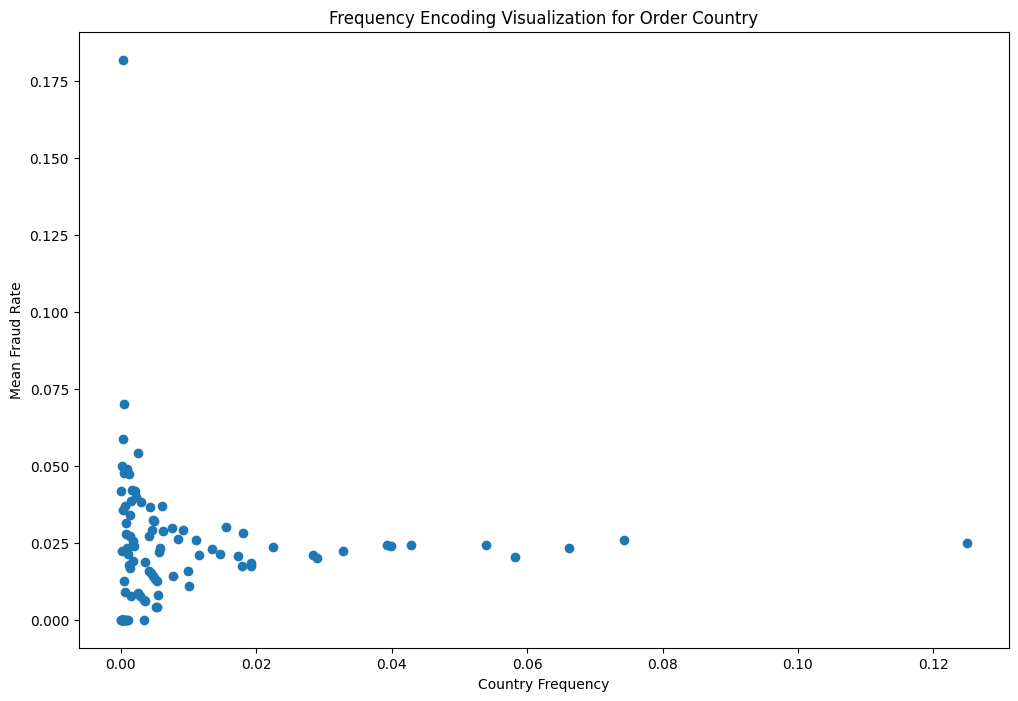

In [36]:
country_freq = X_train_grouped['order_country'].value_counts(normalize=True)
X_train_grouped['country_freq'] = X_train_grouped['order_country'].map(country_freq)

fraud_rate_by_country_freq = X_train_grouped.groupby('country_freq')['fraud'].mean().reset_index()

plt.figure(figsize=(12, 8))
plt.scatter(fraud_rate_by_country_freq['country_freq'], fraud_rate_by_country_freq['fraud'])
plt.xlabel('Country Frequency')
plt.ylabel('Mean Fraud Rate')
plt.title('Frequency Encoding Visualization for Order Country')
plt.show()

X_train_grouped = X_train_grouped.drop('country_freq', axis=1)

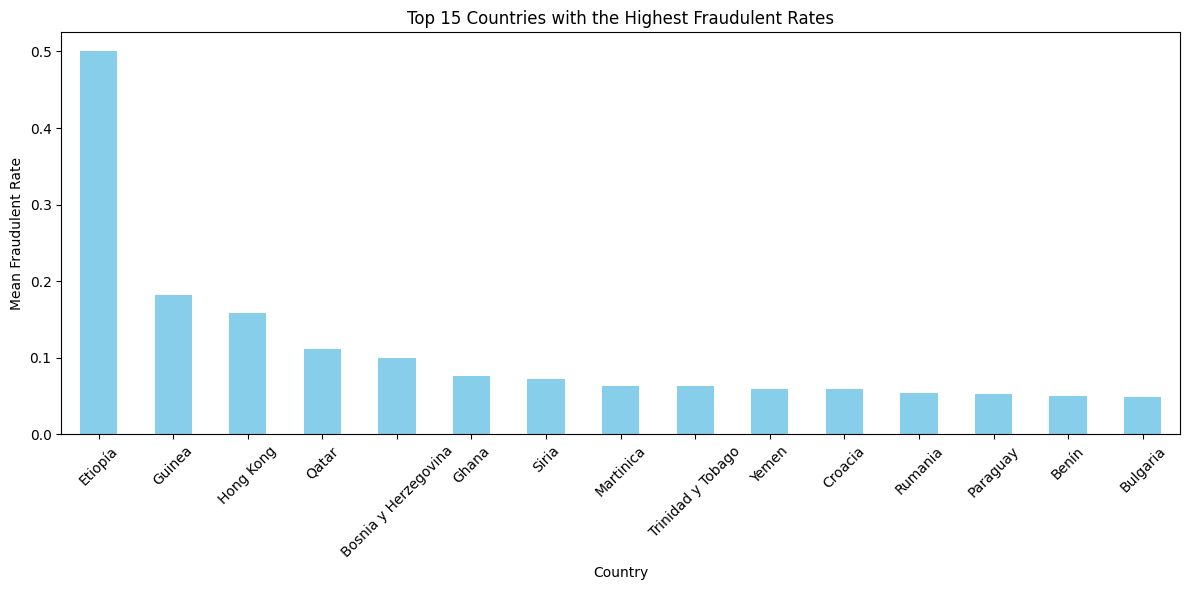

In [37]:
fraud_rates_by_country = X_train_grouped.groupby('order_country')['fraud'].mean()

top_fraud_countries = fraud_rates_by_country.sort_values(ascending=False).head(15)

plt.figure(figsize=(12, 6))
top_fraud_countries.plot(kind='bar', color='skyblue')
plt.title('Top 15 Countries with the Highest Fraudulent Rates')
plt.xlabel('Country')
plt.ylabel('Mean Fraudulent Rate')
plt.xticks(rotation=45)
plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()

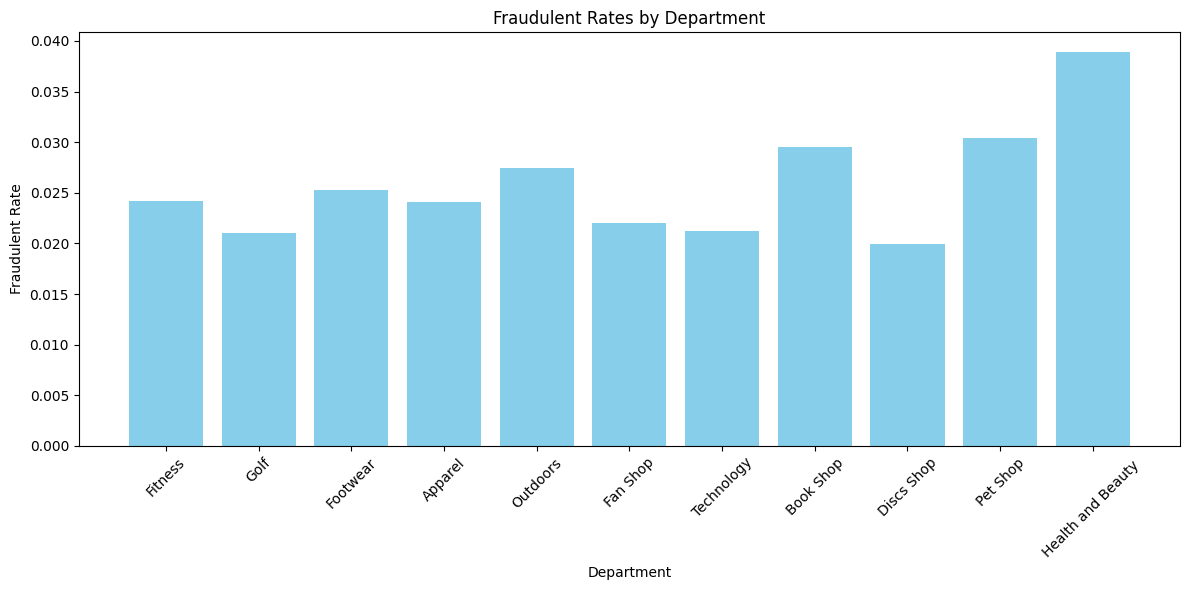

In [38]:
department_fraud_rates = {}
for column in X_train_grouped.columns:
    if column.startswith('Department Name:'):
        # Select only the rows where the department indicator is 1
        department_data = X_train_grouped[X_train_grouped[column] == 1]
        # Calculate the fraud rate for this department
        fraud_rate = department_data['fraud'].mean()
        department_name = column.replace('Department Name: ', '')
        department_fraud_rates[department_name] = fraud_rate

# Step 2: Convert to DataFrame for plotting
fraud_rates_df = pd.DataFrame(list(department_fraud_rates.items()), columns=['Department', 'Fraud Rate'])

# Step 3: Plot the Bar Chart
plt.figure(figsize=(12, 6))
plt.bar(fraud_rates_df['Department'], fraud_rates_df['Fraud Rate'], color='skyblue')
plt.title('Fraudulent Rates by Department')
plt.xlabel('Department')
plt.ylabel('Fraudulent Rate')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [39]:
# function to help with cleaning column names after encoding

def clean_column_names(df):
    df.columns = [re.sub('[^0-9a-zA-Z_]+', '_', col.strip()) for col in df.columns]

### Getting our Base Dataset

We are encoding all remaining features (if needed) to get our **base dataset** to conduct a logistic model for benchmarking.
Variables of the base dataset have a suffix '*_base*' at the end of the variable name.

#### Encoding

In [40]:
# assigning y
y_train_base = X_train_grouped['fraud']
y_test_base = X_test_grouped['fraud']

# dropping y from X
X_train_base = X_train_grouped.drop(['fraud'], axis = 1)
X_test_base = X_test_grouped.drop(['fraud'], axis = 1)

# one hot encoding
columns_to_onehot = ['customer_segment', 'shipping_mode', 'payment_type', 'market', 'order_region']
encoder = OneHotEncoder(handle_unknown="ignore")

# fit encoder on training data
data_ohe = pd.DataFrame(encoder.fit_transform(X_train_base[columns_to_onehot]).toarray())
data_ohe.columns = [col for cols in encoder.categories_ for col in cols]

# Join encoded data with original training data
X_train_base = pd.concat([X_train_base, data_ohe], axis=1).drop(columns_to_onehot, axis=1)

# Transform test data
data_ohe = pd.DataFrame(encoder.transform(X_test_base[columns_to_onehot]).toarray())
data_ohe.columns = [col for cols in encoder.categories_ for col in cols]
X_test_base = pd.concat([X_test_base, data_ohe], axis=1).drop(columns_to_onehot, axis=1)

# frequency encoding
columns_to_frequency_encode = ['order_country', 'order_month', 'order_weekday', 'order_hour', 'shipping_month', 'shipping_weekday', 'shipping_hour']

for col in columns_to_frequency_encode:
    frequency_encoder = ce.CountEncoder(cols=col, normalize=True)
    X_train_base[col] = frequency_encoder.fit_transform(X_train_base[col])
    X_test_base[col] = frequency_encoder.transform(X_test_base[col])

clean_column_names(X_train_base)
clean_column_names(X_test_base)

X_train_base.columns

Index(['num_distinct_items', 'late_delivery_risk', 'order_country',
       'order_item_quantity', 'order_total', 'Category_Name_Sporting_Goods',
       'Category_Name_Shop_By_Sport', 'Category_Name_Women_s_Apparel',
       'Category_Name_Electronics', 'Category_Name_Boxing_MMA',
       ...
       'South_Asia', 'South_of_USA', 'Southeast_Asia', 'Southern_Africa',
       'Southern_Europe', 'US_Center', 'West_Africa', 'West_Asia',
       'West_of_USA', 'Western_Europe'],
      dtype='object', length=232)

#### Scaling

In [41]:
# scale all the numerical columns (everything)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_base = pd.DataFrame(scaler.fit_transform(X_train_base), columns = X_train_base.columns)
X_test_base = pd.DataFrame(scaler.transform(X_test_base), columns = X_test_base.columns)

#### SMOTE

In [42]:
# determine number of samples
desired_samples = 10000
class_counts = dict(zip(*np.unique(y_train_base, return_counts=True)))
resampling_ratio = {class_label: max(desired_samples, count) for class_label, count in class_counts.items()}

# resampling pipeline
resampling_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=resampling_ratio, random_state=0)),
    ('random_undersampler', RandomUnderSampler(sampling_strategy='majority', random_state=0)),
])

X_train_base, y_train_base = resampling_pipeline.fit_resample(X_train_base, y_train_base)

# print before
print('Before: ')
print(X_train_grouped['fraud'].value_counts())
print('\n')

# print after
print('After: ')
print(y_train_base.value_counts())

Before: 
fraud
0    44036
1     1033
Name: count, dtype: int64


After: 
fraud
0    10000
1    10000
Name: count, dtype: int64


# Feature Selection

Feature selection is done based on two methods to get 2 datasets, dataset A and B.

- **Dataset A** - Using Lasso regression, fitting the model with L1 penalty and keeping only the features which do not have coefficient = 0.
- **Dataset B** - Manual selection was conducted based on our intuition of which features are important, or which features are highly correlated

### Dataset A - Lasso regression

#### Encoding

In [43]:
# assigning y
y_train_A = y_train_base
y_test_A = y_test_base

# dropping y from X
X_train_A = X_train_base
X_test_A = X_test_base

# attempt lasso regression to see most important features
lasso_model = linear_model.LogisticRegression(penalty='l1', solver='liblinear', random_state=0)
lasso_model.fit(X_train_A, y_train_A)
coefficients = lasso_model.coef_[0]
feature_names = X_train_A.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
feature_importance_df['Absolute_Coefficient'] = np.abs(feature_importance_df['Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Absolute_Coefficient', ascending=False)
print("Top Features:")
print(feature_importance_df[['Feature', 'Coefficient']])

# Extract feature names with non-zero coefficients
selected_features = feature_importance_df.loc[feature_importance_df['Coefficient'] != 0, 'Feature'].tolist()

# Subset the original dataset based on selected features
X_train_A = X_train_A[selected_features]
X_test_A = X_test_A[selected_features]

print(selected_features)

Top Features:
                                               Feature  Coefficient
1                                   late_delivery_risk   -14.393755
203                                           TRANSFER     9.088196
196                                        First_Class     5.509609
51                      Category_Name_Men_s_Golf_Clubs    -4.592750
92   Product_Name_Glove_It_Women_s_Imperial_Golf_Glove     3.849626
..                                                 ...          ...
57   Product_Name_Under_Armour_Girls_Toddler_Spine_...     0.000000
134                  Product_Name_Fighting_video_games     0.000000
135  Product_Name_Fitbit_The_One_Wireless_Activity_...     0.000000
136  Product_Name_Stiga_Master_Series_ST3100_Compet...     0.000000
116  Product_Name_Field_Stream_Sportsman_16_Gun_Fir...     0.000000

[232 rows x 2 columns]
['late_delivery_risk', 'TRANSFER', 'First_Class', 'Category_Name_Men_s_Golf_Clubs', 'Product_Name_Glove_It_Women_s_Imperial_Golf_Glove', 'Product_

#### Scaling

In [44]:
# scale all the numerical columns (everything)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_A = pd.DataFrame(scaler.fit_transform(X_train_A), columns = X_train_A.columns)
X_test_A = pd.DataFrame(scaler.transform(X_test_A), columns = X_test_A.columns)

#### SMOTE

In [45]:
# determine number of samples
desired_samples = 10000
class_counts = dict(zip(*np.unique(y_train_A, return_counts=True)))
resampling_ratio = {class_label: max(desired_samples, count) for class_label, count in class_counts.items()}

# resampling pipeline
resampling_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=resampling_ratio, random_state=0)),
    ('random_undersampler', RandomUnderSampler(sampling_strategy='majority', random_state=0)),
])

X_train_A, y_train_A = resampling_pipeline.fit_resample(X_train_A, y_train_A)

# print before
print('Before: ')
print(X_train_grouped['fraud'].value_counts())
print('\n')

# print after
print('After: ')
print(y_train_A.value_counts())

Before: 
fraud
0    44036
1     1033
Name: count, dtype: int64


After: 
fraud
0    10000
1    10000
Name: count, dtype: int64


### Dataset B - Manual selection

#### Encoding

In [46]:
product_name_columns = X_train_grouped.filter(like='Product Name').columns
category_name_columns = X_train_grouped.filter(like='Category Name').columns
other_columns_to_drop = ['num_distinct_items', 'order_item_quantity', 'order_total', 'order_region',
                                      'shipping_month', 'shipping_weekday', 'shipping_hour']
all_columns_to_drop = list(product_name_columns) + list(category_name_columns) + other_columns_to_drop

# Remove highly correlated columns and redundant columns
X_train_B = X_train_grouped.drop(all_columns_to_drop, axis = 1)
X_test_B = X_test_grouped.drop(all_columns_to_drop, axis = 1)

# assigning y
y_train_B = X_train_B['fraud']
y_test_B = X_test_B['fraud']

# dropping y from X
X_train_B = X_train_B.drop(['fraud'], axis = 1)
X_test_B = X_test_B.drop(['fraud'], axis = 1)

# one hot encoding
columns_to_onehot = ['customer_segment', 'shipping_mode', 'payment_type', 'market']
encoder = OneHotEncoder(handle_unknown="ignore")

# fit encoder on training data
data_ohe = pd.DataFrame(encoder.fit_transform(X_train_B[columns_to_onehot]).toarray())
data_ohe.columns = [col for cols in encoder.categories_ for col in cols]

# Join encoded data with original training data
X_train_B = pd.concat([X_train_B, data_ohe], axis=1).drop(columns_to_onehot, axis=1)

# Transform test data
data_ohe = pd.DataFrame(encoder.transform(X_test_B[columns_to_onehot]).toarray())
data_ohe.columns = [col for cols in encoder.categories_ for col in cols]
X_test_B = pd.concat([X_test_B, data_ohe], axis=1).drop(columns_to_onehot, axis=1)

# frequency encoding
columns_to_frequency_encode = ['order_country', 'order_month', 'order_weekday', 'order_hour']

for col in columns_to_frequency_encode:
    frequency_encoder = ce.CountEncoder(cols=col, normalize=True)
    X_train_B[col] = frequency_encoder.fit_transform(X_train_B[col])
    X_test_B[col] = frequency_encoder.transform(X_test_B[col])

# dropping more columns
X_train_B = X_train_B.drop(['DEBIT', 'CASH', 'PAYMENT', 'Standard Class'], axis = 1)
X_test_B = X_test_B.drop(['DEBIT', 'CASH', 'PAYMENT', 'Standard Class'], axis = 1)

clean_column_names(X_train_B)
clean_column_names(X_test_B)

print(X_train_B.info())
X_train_B.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45069 entries, 0 to 45068
Data columns (total 29 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   late_delivery_risk                 45069 non-null  int64  
 1   order_country                      45069 non-null  float64
 2   Department_Name_Fitness            45069 non-null  int64  
 3   Department_Name_Golf               45069 non-null  int64  
 4   Department_Name_Footwear           45069 non-null  int64  
 5   Department_Name_Apparel            45069 non-null  int64  
 6   Department_Name_Outdoors           45069 non-null  int64  
 7   Department_Name_Fan_Shop           45069 non-null  int64  
 8   Department_Name_Technology         45069 non-null  int64  
 9   Department_Name_Book_Shop          45069 non-null  int64  
 10  Department_Name_Discs_Shop         45069 non-null  int64  
 11  Department_Name_Pet_Shop           45069 non-null  int

Index(['late_delivery_risk', 'order_country', 'Department_Name_Fitness',
       'Department_Name_Golf', 'Department_Name_Footwear',
       'Department_Name_Apparel', 'Department_Name_Outdoors',
       'Department_Name_Fan_Shop', 'Department_Name_Technology',
       'Department_Name_Book_Shop', 'Department_Name_Discs_Shop',
       'Department_Name_Pet_Shop', 'Department_Name_Health_and_Beauty',
       'Department_Name_Unknown', 'order_month', 'order_weekday', 'order_hour',
       'Consumer', 'Corporate', 'Home_Office', 'First_Class', 'Same_Day',
       'Second_Class', 'TRANSFER', 'Africa', 'Europe', 'LATAM', 'Pacific_Asia',
       'USCA'],
      dtype='object')

#### Scaling

In [47]:
# scale all the numerical columns (everything)
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_B = pd.DataFrame(scaler.fit_transform(X_train_B), columns = X_train_B.columns)
X_test_B = pd.DataFrame(scaler.transform(X_test_B), columns = X_test_B.columns)

#### SMOTE

In [48]:
# determine number of samples
desired_samples = 10000
class_counts = dict(zip(*np.unique(y_train_B, return_counts=True)))
resampling_ratio = {class_label: max(desired_samples, count) for class_label, count in class_counts.items()}

# resampling pipeline
resampling_pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=resampling_ratio, random_state=0)),
    ('random_undersampler', RandomUnderSampler(sampling_strategy='majority', random_state=0)),
])

X_train_B, y_train_B = resampling_pipeline.fit_resample(X_train_B, y_train_B)

# print before
print('Before: ')
print(X_train_grouped['fraud'].value_counts())
print('\n')

# print after
print('After: ')
print(y_train_B.value_counts())

Before: 
fraud
0    44036
1     1033
Name: count, dtype: int64


After: 
fraud
0    10000
1    10000
Name: count, dtype: int64


# Model Training and Evaluation

To find out whether feature engineering using lasso regression or using our manual selection will perform better, we first train a logistic model using the base dataset to use as a benchmark. Then, a logistic model is trained on dataset A and dataset B, before being compared to decide on the dataset which performs better.

In [49]:
# Functions to help with model evaluation

# store results in a dataframe
model_df = pd.DataFrame(columns=[
    'Model Name',
    'Accuracy',
    'Recall',
    'Precision',
    'Specificity',
    'F1 Score',
    'AUC'
])

# Takes in predicted and actual fraud values and prints the evaluation metrics
def evaluate(y_true, y_pred, model, X_test):
	global model_df
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

	accuracy = (tn + tp) / sum([tn, fp, fn, tp])
	recall = tp / sum([fn, tp])
	precision = tp / sum([fp, tp])
	specificity = tp / sum([fn, tp])
	f1_score = 2 * precision * recall / (precision + recall)
	y_prob = model.predict_proba(X_test)[:, 1]
	auc = roc_auc_score(y_true, y_prob)

	print('Accuracy: ' + str(accuracy))
	print('Recall: ' + str(recall))

	print('Precision: ' + str(precision))
	print('Specificity: ' + str(specificity))
	print('F1 Score: ' + str(f1_score))
	print("AUC:", auc)

	# storing inside dataframe
	metrics = pd.DataFrame({
        'Model Name': [type(model).__name__],
        'Accuracy': [accuracy],
        'Recall': [recall],
        'Precision': [precision],
        'Specificity': [specificity],
        'F1 Score': [f1_score],
        'AUC': [auc]
    })
	model_df = pd.concat([model_df, metrics], ignore_index = True)


	# confusion matrix
	confusion = confusion_matrix(y_true, y_pred)
	labels = ['Non-Fraudulent', 'Fraudulent']
	# plt.figure(figsize=(8, 6))
	# sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
	# plt.xlabel('Predicted')
	# plt.ylabel('Actual')
	# plt.title('Confusion Matrix')
	# plt.show()

### Deciding on Dataset A vs Dataset B

#### Logistic Regression

In [50]:
# base dataset
print('Base Dataset')
log_reg = linear_model.LogisticRegression(random_state=0)
log_reg.fit(X=X_train_base, y=y_train_base)
log_reg_pred = log_reg.predict(X_test_base)

evaluate(y_test_base, log_reg_pred, log_reg, X_test_base)

# dataset A
print('\nDataset A')
log_reg = linear_model.LogisticRegression(random_state=0)
log_reg.fit(X=X_train_A, y=y_train_A)
log_reg_pred = log_reg.predict(X_test_A)

evaluate(y_test_A, log_reg_pred, log_reg, X_test_A)

# dataset B
print('\nDataset B')
log_reg = linear_model.LogisticRegression(random_state=0)
log_reg.fit(X=X_train_B, y=y_train_B)
log_reg_pred = log_reg.predict(X_test_B)

evaluate(y_test_B, log_reg_pred, log_reg, X_test_B)

Base Dataset
Accuracy: 0.8938703665355145
Recall: 1.0
Precision: 0.18163672654690619
Specificity: 1.0
F1 Score: 0.30743243243243246
AUC: 0.9580033454695457

Dataset A
Accuracy: 0.893715054876786
Recall: 1.0
Precision: 0.1814194577352472
Specificity: 1.0
F1 Score: 0.30712116098548764
AUC: 0.9582618007621985

Dataset B
Accuracy: 0.893507972665148
Recall: 1.0
Precision: 0.18113057324840764
Specificity: 1.0
F1 Score: 0.30670711156049885
AUC: 0.9591243865619562


#### LGBM

In [51]:
# base dataset
print('Base Dataset')
lgb_model = lgb.LGBMClassifier(random_state = 0)
lgb_model.fit(X_train_base, y_train_base)
lgb_pred = lgb_model.predict(X_test_base)

evaluate(y_test_base, lgb_pred, lgb_model, X_test_base)

# dataset A
print('\nDataset A')
lgb_model = lgb.LGBMClassifier(random_state = 0)
lgb_model.fit(X_train_A, y_train_A)
lgb_pred = lgb_model.predict(X_test_A)

evaluate(y_test_A, lgb_pred, lgb_model, X_test_A)

# dataset B
print('\nDataset B')
lgb_model = lgb.LGBMClassifier(random_state = 0)
lgb_model.fit(X_train_B, y_train_B)
lgb_pred = lgb_model.predict(X_test_B)

evaluate(y_test_B, lgb_pred, lgb_model, X_test_B)

Base Dataset
Accuracy: 0.9369952371091324
Recall: 0.610989010989011
Precision: 0.2109256449165402
Specificity: 0.610989010989011
F1 Score: 0.3135927805978567
AUC: 0.9585347053137733

Dataset A
Accuracy: 0.9369952371091324
Recall: 0.6659340659340659
Precision: 0.22149122807017543
Specificity: 0.6659340659340659
F1 Score: 0.33241908941305537
AUC: 0.9604695076939391

Dataset B
Accuracy: 0.9284013253261545
Recall: 0.6681318681318681
Precision: 0.19791666666666666
Specificity: 0.6681318681318681
F1 Score: 0.3053741838272225
AUC: 0.956071281456998


#### Random Forest

In [52]:
# base dataset
print('Dase Dataset')
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_train_base, y_train_base)
rf_pred = rf_classifier.predict(X_test_base)

evaluate(y_test_base, rf_pred, rf_classifier, X_test_base)

# dataset A
print('\nDataset A')
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_train_A, y_train_A)
rf_pred = rf_classifier.predict(X_test_A)

evaluate(y_test_A, rf_pred, rf_classifier, X_test_A)


# dataset B
print('\nDataset B')
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_train_B, y_train_B)
rf_pred = rf_classifier.predict(X_test_B)

evaluate(y_test_B, rf_pred, rf_classifier, X_test_B)


Dase Dataset
Accuracy: 0.9458997722095672
Recall: 0.43956043956043955
Precision: 0.20202020202020202
Specificity: 0.43956043956043955
F1 Score: 0.2768166089965398
AUC: 0.9489261811832196

Dataset A
Accuracy: 0.9315075585007248
Recall: 0.6461538461538462
Precision: 0.20192307692307693
Specificity: 0.6461538461538462
F1 Score: 0.3076923076923077
AUC: 0.9528640703445856

Dataset B
Accuracy: 0.9170118036860634
Recall: 0.778021978021978
Precision: 0.19073275862068967
Specificity: 0.778021978021978
F1 Score: 0.3063608827347469
AUC: 0.9525548678562834


#### Results

In [53]:
model_df.sort_values(by=['Recall', 'AUC'], ascending=False).rename({0: 'Base Dataset', 1: 'Dataset A', 2: 'Dataset B', 3: 'Base Dataset', 4: 'Dataset A', 5: 'Dataset B', 6: 'Base Dataset', 7: 'Dataset A', 8: 'Dataset B'})

,Model Name,Accuracy,Recall,Precision,Specificity,F1 Score,AUC
Dataset B,LogisticRegression,0.893508,1.000000,0.181131,1.000000,0.306707,0.959124
Dataset A,LogisticRegression,0.893715,1.000000,0.181419,1.000000,0.307121,0.958262
Base Dataset,LogisticRegression,0.893870,1.000000,0.181637,1.000000,0.307432,0.958003
Dataset B,RandomForestClassifier,0.917012,0.778022,0.190733,0.778022,0.306361,0.952555
Dataset B,LGBMClassifier,0.928401,0.668132,0.197917,0.668132,0.305374,0.956071
Dataset A,LGBMClassifier,0.936995,0.665934,0.221491,0.665934,0.332419,0.960470
Dataset A,RandomForestClassifier,0.931508,0.646154,0.201923,0.646154,0.307692,0.952864
Base Dataset,LGBMClassifier,0.936995,0.610989,0.210926,0.610989,0.313593,0.958535
Base Dataset,RandomForestClassifier,0.945900,0.439560,0.202020,0.439560,0.276817,0.948926


explanation here for choosing Dataset B

### Running Models using Dataset B

In [54]:
# Functions to help with model evaluation

# store results in a dataframe
model_df = pd.DataFrame(columns=[
    'Model Name',
    'Accuracy',
    'Recall',
    'Precision',
    'Specificity',
    'F1 Score',
    'AUC'
])

# Takes in predicted and actual fraud values and prints the evaluation metrics
def evaluate(y_true, y_pred, model, X_test):
	global model_df
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

	accuracy = (tn + tp) / sum([tn, fp, fn, tp])
	recall = tp / sum([fn, tp])
	precision = tp / sum([fp, tp])
	specificity = tp / sum([fn, tp])
	f1_score = 2 * precision * recall / (precision + recall)
	y_prob = model.predict_proba(X_test)[:, 1]
	auc = roc_auc_score(y_true, y_prob)

	print('Accuracy: ' + str(accuracy))
	print('Recall: ' + str(recall))

	print('Precision: ' + str(precision))
	print('Specificity: ' + str(specificity))
	print('F1 Score: ' + str(f1_score))
	print("AUC:", auc)

	# storing inside dataframe
	metrics = pd.DataFrame({
        'Model Name': [type(model).__name__],
        'Accuracy': [accuracy],
        'Recall': [recall],
        'Precision': [precision],
        'Specificity': [specificity],
        'F1 Score': [f1_score],
        'AUC': [auc]
    })
	model_df = pd.concat([model_df, metrics], ignore_index = True)


	# confusion matrix
	confusion = confusion_matrix(y_true, y_pred)
	labels = ['Non-Fraudulent', 'Fraudulent']
	# plt.figure(figsize=(8, 6))
	# sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
	# plt.xlabel('Predicted')
	# plt.ylabel('Actual')
	# plt.title('Confusion Matrix')
	# plt.show()

#### Logistic Regression

In [55]:
log_reg = linear_model.LogisticRegression(random_state=0)
log_reg.fit(X=X_train_B, y=y_train_B)
log_reg_pred = log_reg.predict(X_test_B)

evaluate(y_test_B, log_reg_pred, log_reg, X_test_B)

Accuracy: 0.893507972665148
Recall: 1.0
Precision: 0.18113057324840764
Specificity: 1.0
F1 Score: 0.30670711156049885
AUC: 0.9591243865619562


In [56]:
# analyse top 10 weights of the coefficients
feature_importances = log_reg.coef_[0]
abs_feature_importances = abs(feature_importances)
sorted_indices = abs_feature_importances.argsort()
top_10_features = sorted_indices[::-1][:10]
top_10_importances = feature_importances[top_10_features]
top_10_feature_names = [log_reg.feature_names_in_[i] for i in top_10_features]
for feature, importance in zip(top_10_feature_names, top_10_importances):
    print(f"{feature}: {importance}")

late_delivery_risk: -9.068810002561458
TRANSFER: 8.106995672196778
First_Class: 3.24100518201193
Department_Name_Outdoors: -1.1322885843720973
Department_Name_Health_and_Beauty: -1.0308802105230765
Department_Name_Technology: -0.97818076811528
Second_Class: 0.9224579611012468
Department_Name_Fan_Shop: -0.819429757198623
Department_Name_Fitness: -0.7447150646206109
Department_Name_Golf: -0.5269614975783748


#### Random Forest

Accuracy: 0.9170118036860634
Recall: 0.778021978021978
Precision: 0.19073275862068967
Specificity: 0.778021978021978
F1 Score: 0.3063608827347469
AUC: 0.9525548678562834


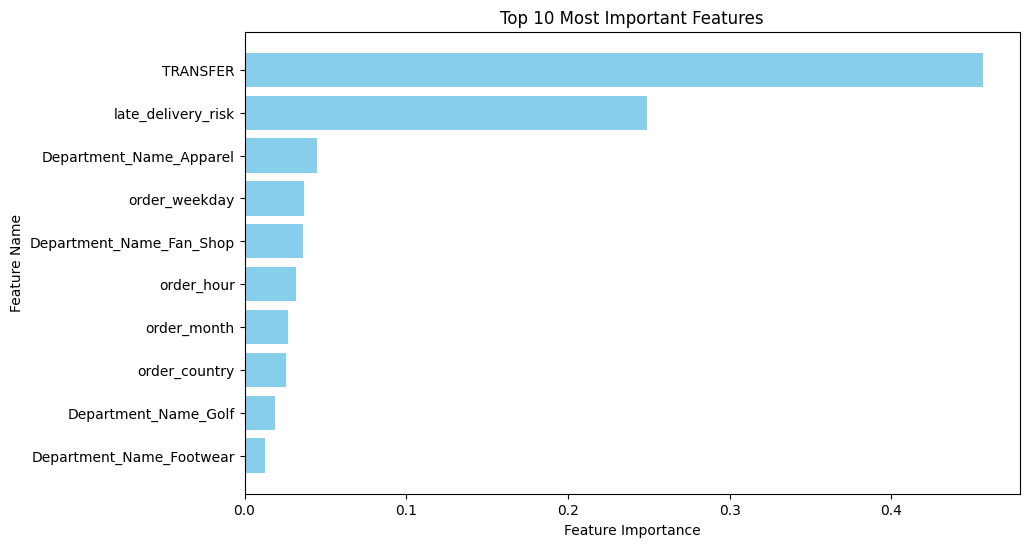

In [57]:
# rf classifier
rf_classifier = RandomForestClassifier(random_state=0)
rf_classifier.fit(X_train_B, y_train_B)
rf_pred = rf_classifier.predict(X_test_B)

evaluate(y_test_B, rf_pred, rf_classifier, X_test_B)

# plot top 10 important features
feature_importances = rf_classifier.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]
top_n = 10
top_feature_indices = sorted_indices[:top_n]
top_feature_importances = feature_importances[top_feature_indices]
top_feature_names = X_train_B.columns[top_feature_indices]

# Create a bar plot for the top features
plt.figure(figsize=(10, 6))
plt.barh(top_feature_names, top_feature_importances, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important feature at the top
plt.yticks(top_feature_names)
plt.show()

#### Gradient Boosting Classifier

In [58]:
gradient_boosting_model = GradientBoostingClassifier(random_state=0)
gradient_boosting_model.fit(X_train_B, y_train_B)
gradient_boosting_pred = gradient_boosting_model.predict(X_test_B)

evaluate(y_test_B, gradient_boosting_pred, gradient_boosting_model, X_test_B)

Accuracy: 0.8971836819217229
Recall: 0.9648351648351648
Precision: 0.18223329182233292
Specificity: 0.9648351648351648
F1 Score: 0.30656424581005587
AUC: 0.9572064222294856


#### SVC

In [59]:
svc_model = SVC(probability=True, random_state=0)
svc_model.fit(X_train_B, y_train_B)
svc_pred = svc_model.predict(X_test_B)

evaluate(y_test_B, svc_pred, svc_model, X_test_B)

Accuracy: 0.8940256781942432
Recall: 0.989010989010989
Precision: 0.18057784911717495
Specificity: 0.989010989010989
F1 Score: 0.3053953172718018
AUC: 0.9481650315116196


#### K Nearest Neighbours

In [60]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_B, y_train_B)
knn_pred = knn_model.predict(X_test_B)

evaluate(y_test_B, knn_pred, knn_model, X_test_B)

Accuracy: 0.9032408366121351
Recall: 0.9120879120879121
Precision: 0.18493761140819964
Specificity: 0.9120879120879121
F1 Score: 0.30752130418673584
AUC: 0.9435958612195291


#### Naive Bayes

In [61]:
naive_bayes_model = GaussianNB()
naive_bayes_model.fit(X_train_B, y_train_B)
naive_bayes_pred = naive_bayes_model.predict(X_test_B)

evaluate(y_test_B, naive_bayes_pred, naive_bayes_model, X_test_B)

Accuracy: 0.8949057775937047
Recall: 0.9802197802197802
Precision: 0.18078638021888935
Specificity: 0.9802197802197802
F1 Score: 0.30527036276522934
AUC: 0.9457849822093499


#### MLP

In [62]:
mlp_model = MLPClassifier(random_state=0)
mlp_model.fit(X_train_B, y_train_B)
mlp_pred = mlp_model.predict(X_test_B)

evaluate(y_test_B, mlp_pred, mlp_model, X_test_B)

Accuracy: 0.9051563470697868
Recall: 0.8703296703296703
Precision: 0.1825726141078838
Specificity: 0.8703296703296703
F1 Score: 0.3018292682926829
AUC: 0.9557859085932889


#### XGB

In [63]:
xgb_model = xgb.XGBClassifier(random_state=0)
xgb_model.fit(X_train_B, y_train_B)
xgb_pred = xgb_model.predict(X_test_B)

evaluate(y_test_B, xgb_pred, xgb_model, X_test_B)

Accuracy: 0.9391178297784221
Recall: 0.5868131868131868
Precision: 0.21274900398406374
Specificity: 0.5868131868131868
F1 Score: 0.312280701754386
AUC: 0.955442389115047


#### LBGM

In [64]:
lgb_model = lgb.LGBMClassifier(random_state = 0)
lgb_model.fit(X_train_B, y_train_B)
lgb_pred = lgb_model.predict(X_test_B)

evaluate(y_test_B, lgb_pred, lgb_model, X_test_B)

Accuracy: 0.9284013253261545
Recall: 0.6681318681318681
Precision: 0.19791666666666666
Specificity: 0.6681318681318681
F1 Score: 0.3053741838272225
AUC: 0.956071281456998


#### AdaBoost

In [65]:
adaboost_model = AdaBoostClassifier(random_state = 0)
adaboost_model.fit(X_train_B, y_train_B)
adaboost_pred = adaboost_model.predict(X_test_B)

evaluate(y_test_B, adaboost_pred, adaboost_model, X_test_B)

Accuracy: 0.8983744046386415
Recall: 0.9736263736263736
Precision: 0.18504594820384293
Specificity: 0.9736263736263736
F1 Score: 0.3109863109863109
AUC: 0.9580521117184073


#### Overall Results

In [66]:
model_df.sort_values(by=['AUC', 'Recall'], ascending=False)

,Model Name,Accuracy,Recall,Precision,Specificity,F1 Score,AUC
0,LogisticRegression,0.893508,1.000000,0.181131,1.000000,0.306707,0.959124
9,AdaBoostClassifier,0.898374,0.973626,0.185046,0.973626,0.310986,0.958052
2,GradientBoostingClassifier,0.897184,0.964835,0.182233,0.964835,0.306564,0.957206
8,LGBMClassifier,0.928401,0.668132,0.197917,0.668132,0.305374,0.956071
6,MLPClassifier,0.905156,0.870330,0.182573,0.870330,0.301829,0.955786
7,XGBClassifier,0.939118,0.586813,0.212749,0.586813,0.312281,0.955442
1,RandomForestClassifier,0.917012,0.778022,0.190733,0.778022,0.306361,0.952555
3,SVC,0.894026,0.989011,0.180578,0.989011,0.305395,0.948165
5,GaussianNB,0.894906,0.980220,0.180786,0.980220,0.305270,0.945785
4,KNeighborsClassifier,0.903241,0.912088,0.184938,0.912088,0.307521,0.943596


# Hyperparameter Tuning

In [67]:
# store results in a dataframe
model_tuned_df = pd.DataFrame(columns=[
    'Model Name',
    'Accuracy',
    'Recall',
    'Precision',
    'Specificity',
    'F1 Score',
    'AUC'
])

X_resampled = X_train_B
y_resampled = y_train_B
X_test_final = X_test_B
y_test_final = y_test_B

# Takes in predicted and actual fraud values and prints the evaluation metrics
def evaluate(y_true, y_pred, model, X_test):
	global model_tuned_df
	tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()

	accuracy = (tn + tp) / sum([tn, fp, fn, tp])
	recall = tp / sum([fn, tp])
	precision = tp / sum([fp, tp])
	specificity = tp / sum([fn, tp])
	f1_score = 2 * precision * recall / (precision + recall)
	y_prob = model.predict_proba(X_test)[:, 1]
	auc = roc_auc_score(y_true, y_prob)

	print('Accuracy: ' + str(accuracy))
	print('Recall: ' + str(recall))
	print('Precision: ' + str(precision))
	print('Specificity: ' + str(specificity))
	print('F1 Score: ' + str(f1_score))
	print("AUC:", auc)

	# storing inside dataframe
	metrics = pd.DataFrame({
        'Model Name': [type(model).__name__],
        'Accuracy': [accuracy],
        'Recall': [recall],
        'Precision': [precision],
        'Specificity': [specificity],
        'F1 Score': [f1_score],
        'AUC': [auc]
    })
	model_tuned_df = pd.concat([model_tuned_df, metrics], ignore_index = True)


	# confusion matrix
	confusion = confusion_matrix(y_true, y_pred)
	labels = ['Non-Fraudulent', 'Fraudulent']
	plt.figure(figsize=(8, 6))
	sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
	plt.xlabel('Predicted')
	plt.ylabel('Actual')
	plt.title('Confusion Matrix')
	plt.show()

### Logistic Regression

Best Hyperparameters: {'C': 0.1, 'fit_intercept': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy: 0.893507972665148
Recall: 1.0
Precision: 0.18113057324840764
Specificity: 1.0
F1 Score: 0.30670711156049885
AUC: 0.9590992168851242


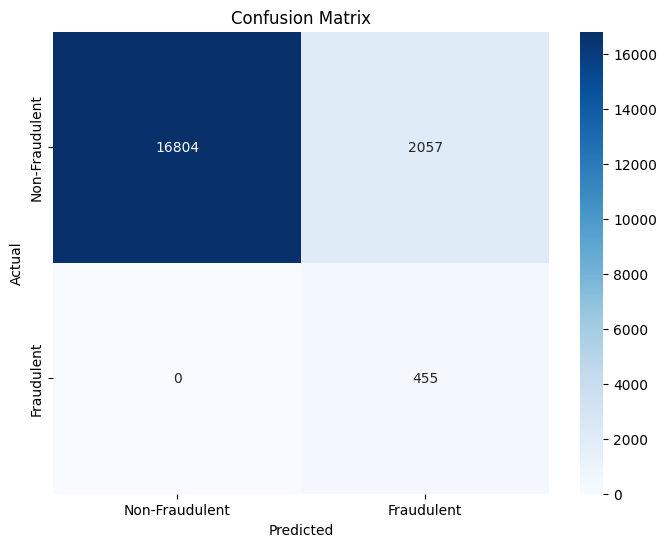

In [68]:
# logistic regression
param_grid = {
    'penalty': [None, 'l1', 'l2', 'elasticnet'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'newton-cg', 'lgfbs', 'sag', 'saga'],
    'fit_intercept': [True, False]
}

# tuning
log_reg = linear_model.LogisticRegression(random_state=0)
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_resampled, y_resampled)

# best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# using optimal model
best_log_reg = grid_search.best_estimator_
log_reg_pred = best_log_reg.predict(X_test_final)

# store in df
evaluate(y_test_final, log_reg_pred, best_log_reg, X_test_final)

In [69]:
# analyse top 10 weights of the coefficients
feature_importances = best_log_reg.coef_[0]
abs_feature_importances = abs(feature_importances)
sorted_indices = abs_feature_importances.argsort()
top_10_features = sorted_indices[::-1][:10]
top_10_importances = feature_importances[top_10_features]
top_10_feature_names = [best_log_reg.feature_names_in_[i] for i in top_10_features]
for feature, importance in zip(top_10_feature_names, top_10_importances):
    print(f"{feature}: {importance}")

TRANSFER: 5.990233500128663
late_delivery_risk: -5.912987873424224
First_Class: 1.646195804519806
Second_Class: 0.6697868073189813
Department_Name_Technology: -0.5559713602910812
Department_Name_Outdoors: -0.47574689035116
Department_Name_Fan_Shop: -0.3790191240466647
Department_Name_Health_and_Beauty: -0.3674484938925861
order_month: -0.27924814038999674
order_country: 0.2693725684386112


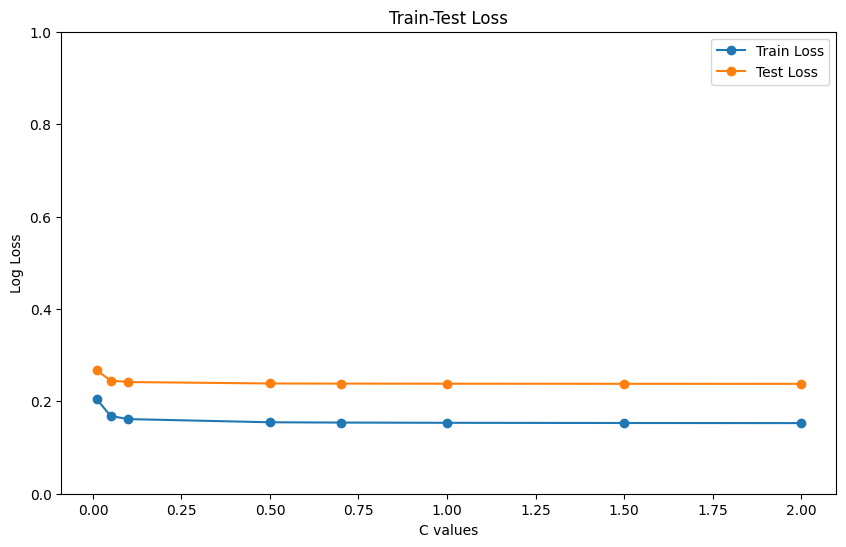

In [70]:
# train-test loss evaluation with C
C_values = [0.01, 0.05, 0.1, 0.5, 0.7, 1, 1.5, 2]

# lists to store train and test loss values
train_loss_values = []
test_loss_values = []

for C in C_values:
    # create a RandomForestClassifier with the current n_estimators value
    log_reg_model = linear_model.LogisticRegression(C=C, random_state=0)

    # fit the model on the training data
    log_reg_model.fit(X_resampled, y_resampled)

    # predict probabilities on the training set
    train_probs = log_reg_model.predict_proba(X_resampled)[:, 1]

    # predict probabilities on the test set
    test_probs = log_reg_model.predict_proba(X_test_final)[:, 1]

    # calculate log loss for training and test sets
    train_loss = log_loss(y_resampled, train_probs)
    test_loss = log_loss(y_test_final, test_probs)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

# plotting graphs
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_loss_values, label='Train Loss', marker='o')
plt.plot(C_values, test_loss_values, label='Test Loss', marker='o')
plt.xlabel('C values')
plt.ylabel('Log Loss')
plt.title('Train-Test Loss')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.show()

### Adaboost

GridSearchCV(cv=5, estimator=AdaBoostClassifier(random_state=0),
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.01, 0.1, 1.0],
                         'n_estimators': [50, 100, 150, 200]},
             scoring='roc_auc')
Best Hyperparameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.0, 'n_estimators': 200}
Accuracy: 0.9062952992337958
Recall: 0.8725274725274725
Precision: 0.1847370870172173
Specificity: 0.8725274725274725
F1 Score: 0.3049155145929339
AUC: 0.9571626083475933


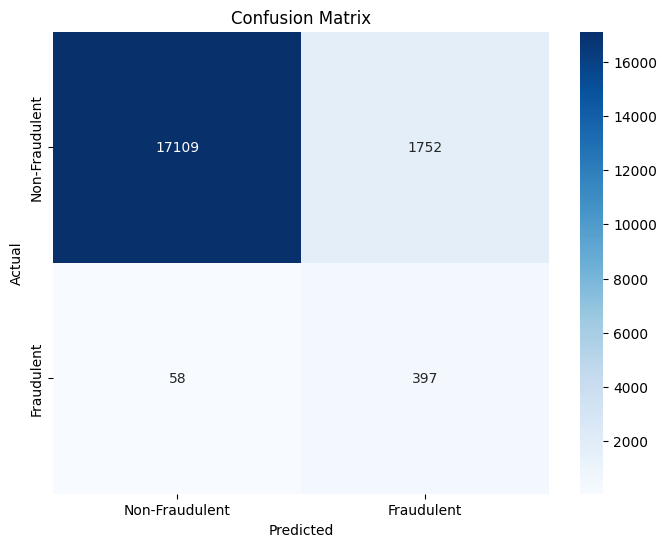

In [71]:
# adaboost model
param_grid = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.1, 1.0],
    'algorithm': ['SAMME', 'SAMME.R']
}

# tuning
ada_boost = AdaBoostClassifier(random_state=0)
grid_search = GridSearchCV(ada_boost, param_grid=param_grid, cv=5, scoring='roc_auc')
print(grid_search)
grid_search.fit(X_resampled, y_resampled)

# best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# using optimal model
best_ada_boost = grid_search.best_estimator_
ada_boost_pred = best_ada_boost.predict(X_test_final)

# store in df
evaluate(y_test_final, ada_boost_pred, best_ada_boost, X_test_final)

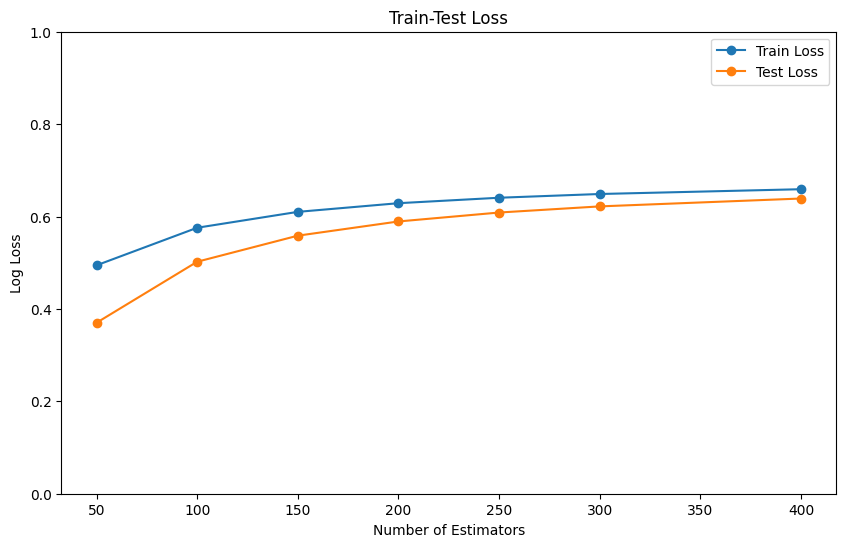

In [72]:
# train-test loss over n_estimators
n_estimators_values = [50, 100, 150, 200, 250, 300, 400]

# lists to store train and test loss values
train_loss_values = []
test_loss_values = []

for n_estimators in n_estimators_values:
    # create a RandomForestClassifier with the current n_estimators value
    ada_model = AdaBoostClassifier(n_estimators=n_estimators, random_state=0)

    # fit the model on the training data
    ada_model.fit(X_resampled, y_resampled)

    # predict probabilities on the training set
    train_probs = ada_model.predict_proba(X_resampled)[:, 1]

    # predict probabilities on the test set
    test_probs = ada_model.predict_proba(X_test_final)[:, 1]

    # calculate log loss for training and test sets
    train_loss = log_loss(y_resampled, train_probs)
    test_loss = log_loss(y_test_final, test_probs)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

# plotting graphs
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_loss_values, label='Train Loss', marker='o')
plt.plot(n_estimators_values, test_loss_values, label='Test Loss', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Log Loss')
plt.title('Train-Test Loss')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.show()

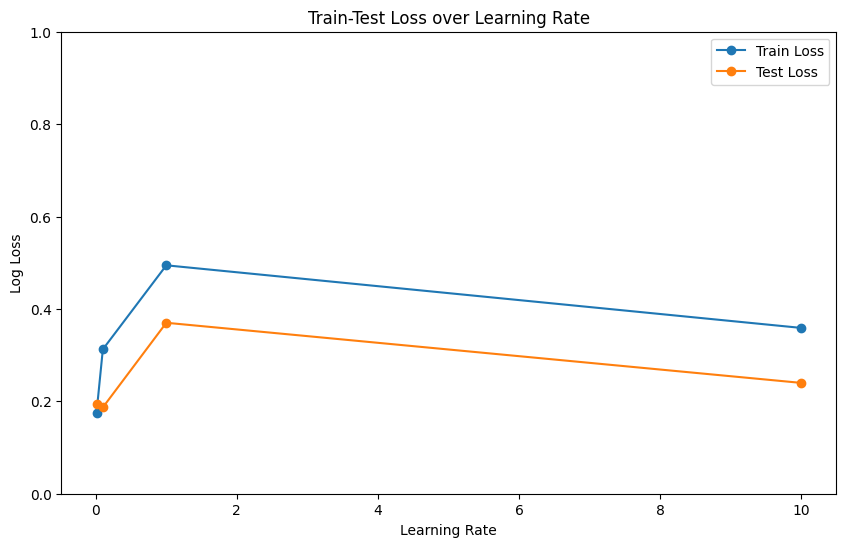

In [73]:
# train-test loss over learning rates
lrate_values = [0.01, 0.1, 1, 10]

# lists to store train and test loss values
train_loss_values = []
test_loss_values = []

for lrate in lrate_values:
    ada_model = AdaBoostClassifier(learning_rate=lrate, random_state=0)

    # fit the model on the training data
    ada_model.fit(X_resampled, y_resampled)

    # predict probabilities on the training set
    train_probs = ada_model.predict_proba(X_resampled)[:, 1]

    # predict probabilities on the test set
    test_probs = ada_model.predict_proba(X_test_final)[:, 1]

    # calculate log loss for training and test sets
    train_loss = log_loss(y_resampled, train_probs)
    test_loss = log_loss(y_test_final, test_probs)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

# plotting graphs
plt.figure(figsize=(10, 6))
plt.plot(lrate_values, train_loss_values, label='Train Loss', marker='o')
plt.plot(lrate_values, test_loss_values, label='Test Loss', marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('Log Loss')
plt.title('Train-Test Loss over Learning Rate')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.show()

### Gradient Boosting 

Best Hyperparameters: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 3, 'min_samples_split': 4, 'n_estimators': 150, 'subsample': 0.8}
Accuracy: 0.9302650652308967
Recall: 0.6285714285714286
Precision: 0.1953551912568306
Specificity: 0.6285714285714286
F1 Score: 0.29807191245440334
AUC: 0.9539982789068203


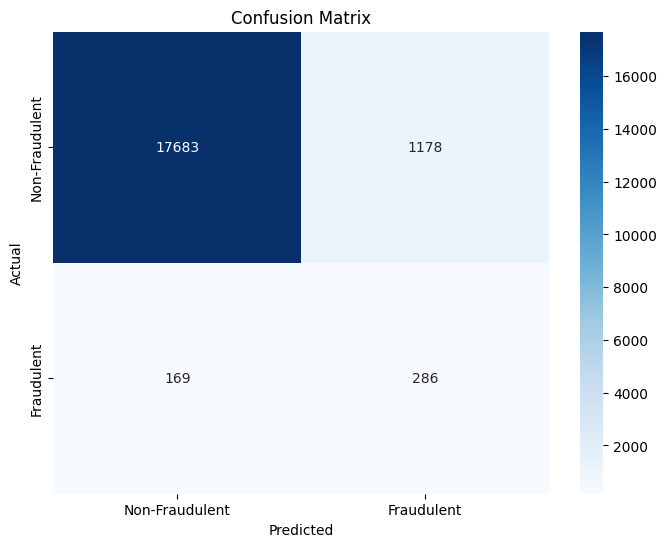

In [74]:
# gradient boosting model
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 3, 6],
    'subsample': [0.8, 1.0],
    'min_samples_split': [4, 6],
    'min_samples_leaf': [2, 3],
    'criterion': ['friedman_mse', 'squared_error']
}

# tuning
gb_model = GradientBoostingClassifier(random_state=0)
grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_resampled, y_resampled)

# best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# using optimal model
best_gb_model = grid_search.best_estimator_
gb_pred = best_gb_model.predict(X_test_final)

# store in df
evaluate(y_test_final, gb_pred, best_gb_model, X_test_final)

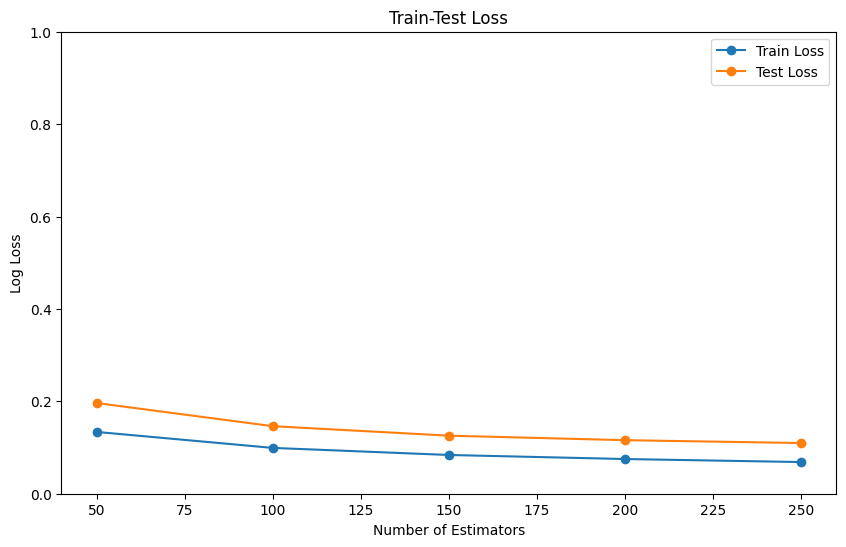

In [75]:
# train-test loss for Gradient Classifier over n estimators
n_estimators_values = [50, 100, 150, 200, 250]

# lists to store train and test loss values
train_loss_values = []
test_loss_values = []

for n_estimators in n_estimators_values:

    gb_model = GradientBoostingClassifier(n_estimators=n_estimators, random_state=0)

    # fit the model on the training data
    gb_model.fit(X_resampled, y_resampled)

    # predict probabilities on the training set
    train_probs = gb_model.predict_proba(X_resampled)[:, 1]

    # predict probabilities on the test set
    test_probs = gb_model.predict_proba(X_test_final)[:, 1]

    # calculate log loss for training and test sets
    train_loss = log_loss(y_resampled, train_probs)
    test_loss = log_loss(y_test_final, test_probs)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

# plotting graphs
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_loss_values, label='Train Loss', marker='o')
plt.plot(n_estimators_values, test_loss_values, label='Test Loss', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Log Loss')
plt.title('Train-Test Loss')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.show()

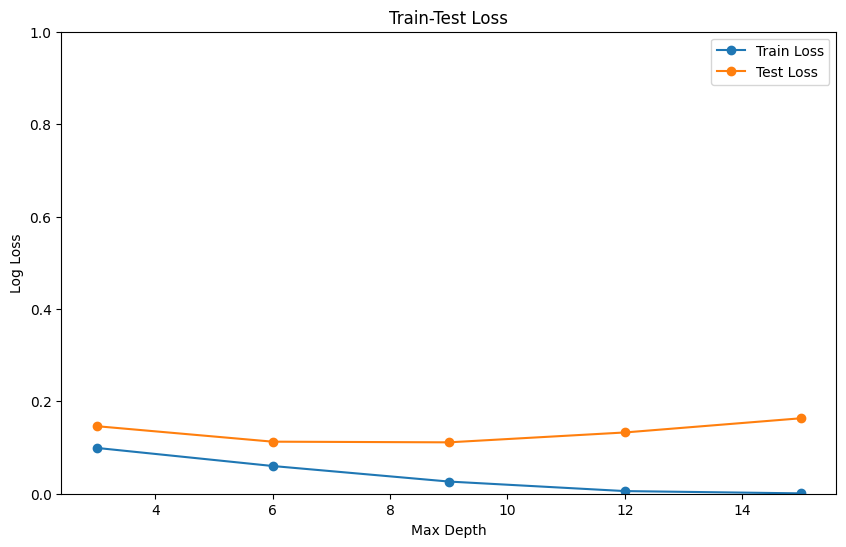

In [76]:
# train-test loss for Gradient Boosting Classifier over max depth
max_depth_values = [None, 3, 6, 9, 12, 15]

# lists to store train and test loss values
train_loss_values = []
test_loss_values = []

for max_depth in max_depth_values:

    gb_model = GradientBoostingClassifier(max_depth=max_depth, random_state=0)

    # fit the model on the training data
    gb_model.fit(X_resampled, y_resampled)

    # predict probabilities on the training set
    train_probs = gb_model.predict_proba(X_resampled)[:, 1]

    # predict probabilities on the test set
    test_probs = gb_model.predict_proba(X_test_final)[:, 1]

    # calculate log loss for training and test sets
    train_loss = log_loss(y_resampled, train_probs)
    test_loss = log_loss(y_test_final, test_probs)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

# plotting graphs
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_loss_values, label='Train Loss', marker='o')
plt.plot(max_depth_values, test_loss_values, label='Test Loss', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Log Loss')
plt.title('Train-Test Loss')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.show()

### LGBM

Best Hyperparameters: {'colsample_bytree': 0.8, 'max_depth': 10, 'min_child_samples': 5, 'min_child_weight': 1, 'n_estimators': 200, 'subsample': 0.6}
Accuracy: 0.9391178297784221
Recall: 0.5912087912087912
Precision: 0.2136616362192216
Specificity: 0.5912087912087912
F1 Score: 0.3138856476079347
AUC: 0.9561287289138412


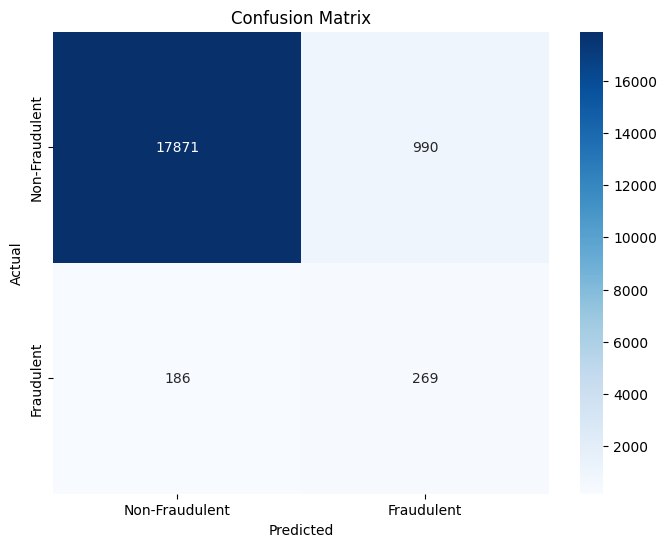

In [77]:
# lgb model
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_child_samples': [2, 5, 10],
    'min_child_weight': [1e-1, 1, 1e1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# tuning
lgb_model = lgb.LGBMClassifier(random_state=0)
grid_search = GridSearchCV(lgb_model, param_grid, cv=5, scoring='roc_auc')
grid_search.fit(X_resampled, y_resampled)

# best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# using optimal model
best_lgb_model = grid_search.best_estimator_
lgb_pred = best_lgb_model.predict(X_test_final)

# store in df
evaluate(y_test_final, lgb_pred, best_lgb_model, X_test_final)

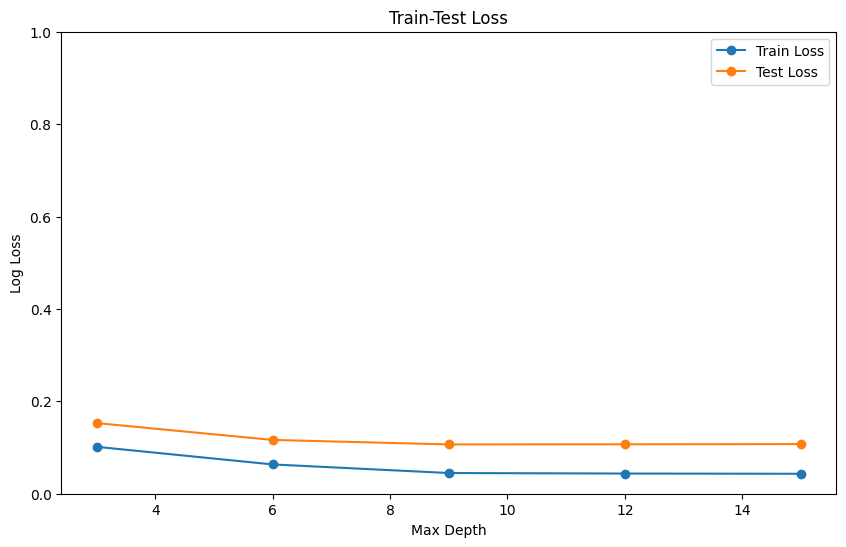

In [78]:
# train-test loss for LGBM Classifier over max depth
max_depth_values = [None, 3, 6, 9, 12, 15]

# lists to store train and test loss values
train_loss_values = []
test_loss_values = []

for max_depth in max_depth_values:

    lgb_model = lgb.LGBMClassifier(max_depth=max_depth, random_state=0)

    # fit the model on the training data
    lgb_model.fit(X_resampled, y_resampled)

    # predict probabilities on the training set
    train_probs = lgb_model.predict_proba(X_resampled)[:, 1]

    # predict probabilities on the test set
    test_probs = lgb_model.predict_proba(X_test_final)[:, 1]

    # calculate log loss for training and test sets
    train_loss = log_loss(y_resampled, train_probs)
    test_loss = log_loss(y_test_final, test_probs)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

# plotting graphs
plt.figure(figsize=(10, 6))
plt.plot(max_depth_values, train_loss_values, label='Train Loss', marker='o')
plt.plot(max_depth_values, test_loss_values, label='Test Loss', marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Log Loss')
plt.title('Train-Test Loss')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.show()

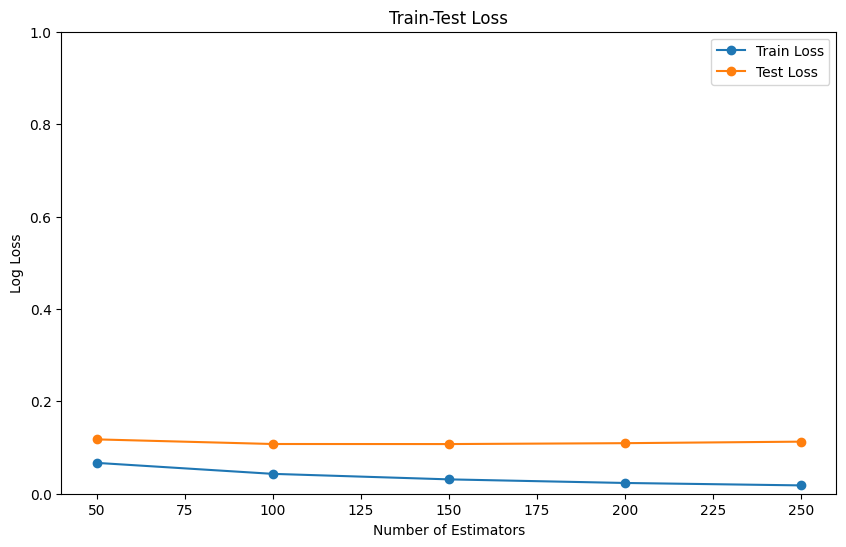

In [79]:
# train-test loss for LGBM Classifier over n estimators
n_estimators_values = [50, 100, 150, 200, 250]

# lists to store train and test loss values
train_loss_values = []
test_loss_values = []

for n_estimators in n_estimators_values:
    # create a RandomForestClassifier with the current n_estimators value
    lgb_model = lgb.LGBMClassifier(n_estimators=n_estimators, random_state=0)

    # fit the model on the training data
    lgb_model.fit(X_resampled, y_resampled)

    # predict probabilities on the training set
    train_probs = lgb_model.predict_proba(X_resampled)[:, 1]

    # predict probabilities on the test set
    test_probs = lgb_model.predict_proba(X_test_final)[:, 1]

    # calculate log loss for training and test sets
    train_loss = log_loss(y_resampled, train_probs)
    test_loss = log_loss(y_test_final, test_probs)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

# plotting graphs
plt.figure(figsize=(10, 6))
plt.plot(n_estimators_values, train_loss_values, label='Train Loss', marker='o')
plt.plot(n_estimators_values, test_loss_values, label='Test Loss', marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Log Loss')
plt.title('Train-Test Loss')
plt.legend(loc='upper right')
plt.ylim(0, 1)
plt.show()

### Overall Results

In [80]:
model_tuned_df.sort_values(by=['AUC', 'Recall'], ascending=False)

,Model Name,Accuracy,Recall,Precision,Specificity,F1 Score,AUC
0,LogisticRegression,0.893508,1.000000,0.181131,1.000000,0.306707,0.959099
1,AdaBoostClassifier,0.906295,0.872527,0.184737,0.872527,0.304916,0.957163
3,LGBMClassifier,0.939118,0.591209,0.213662,0.591209,0.313886,0.956129
2,GradientBoostingClassifier,0.930265,0.628571,0.195355,0.628571,0.298072,0.953998
